<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [SYNOP2] - First predictions at 3h
<!-- DESC --> Episode 2 : Learning session and weather prediction attempt at 3h
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Make a simple prediction (3h)
 - Understanding the use of a recurrent neural network


SYNOP meteorological data, available at: https://public.opendatasoft.com

## What we're going to do :

 - Read our dataset
 - Select our data and normalize it
 - Doing our training
 - Making simple predictions

## Step 1 - Import and init
### 1.1 - Python

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('SYNOP2')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.14
Notebook id          : SYNOP2
Run time             : Wednesday 10 February 2021, 10:55:30
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


### 1.2 - Parameters

In [2]:
# ---- About dataset
#
dataset_dir      = './data'
dataset_filename = 'synop-LYS.csv'
schema_filename  = 'synop.json'
features         = ['tend', 'cod_tend', 'dd', 'ff', 'td', 'u', 'ww', 'pres', 'rafper', 'rr1', 'rr3', 'tc']
features_len     = len(features)

# ---- About training
#
scale            = 1        # Percentage of dataset to be used (1=all)
train_prop       = .8       # Percentage for train (the rest being for the test)
sequence_len     = 16
batch_size       = 32
epochs           = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('scale', 'train_prop', 'sequence_len', 'batch_size', 'epochs')

**\*\* Overrided parameters : \*\***

scale                : 1
train_prop           : 0.8
sequence_len         : 16
batch_size           : 32
epochs               : 10


## Step 2 - Read and prepare dataset
### 2.1 - Read it

In [4]:
# ---- Read dataset from ./data

df = pd.read_csv(f'{dataset_dir}/{dataset_filename}', header=0, sep=';')

# ---- Scaling

df = df[:int(scale*len(df))]
train_len=int(train_prop*len(df))

# ---- Train / Test
dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]
pwk.subtitle('Train dataset example :')
display(dataset_train.head(15))

# ---- Normalize, and convert to numpy array

mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test  = (dataset_test  - mean) / std

pwk.subtitle('After normalization :')
display(dataset_train.describe().style.format("{0:.2f}"))

dataset_train = dataset_train.to_numpy()
dataset_test  = dataset_test.to_numpy()

pwk.subtitle('Shapes :')
print('Dataset       : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)


<br>**Train dataset example :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
0,-120.0,6.0,0.0,0.0,278.75,88.0,60.0,96250.0,4.1,0.0,0.0,7.5
1,-150.0,6.0,60.0,1.0,278.65,93.0,61.0,96100.0,2.6,0.2,0.6,6.6
2,10.0,3.0,280.0,2.1,278.85,95.0,58.0,96110.0,2.6,0.0,0.4,6.4
3,230.0,3.0,310.0,2.6,279.15,96.0,50.0,96340.0,5.7,0.0,3.0,6.6
4,280.0,1.0,330.0,4.6,278.15,94.0,21.0,96620.0,8.7,0.4,0.8,5.9
5,480.0,3.0,350.0,5.1,276.95,91.0,60.0,97100.0,8.2,0.2,0.4,5.2
6,530.0,2.0,350.0,3.1,274.05,83.0,21.0,97630.0,7.2,0.0,0.0,3.5
7,450.0,2.0,340.0,6.2,272.15,81.0,2.0,98080.0,9.3,0.0,0.0,1.9
8,280.0,1.0,320.0,6.2,270.15,74.0,2.0,98360.0,10.3,0.0,0.0,1.1
9,220.0,1.0,290.0,2.6,269.65,72.0,2.0,98580.0,5.1,0.0,0.0,1.0


<br>**After normalization :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
count,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00
mean,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-6.79,-1.59,-1.74,-1.36,-5.22,-3.85,-0.53,-4.97,-1.62,-0.32,-0.27,-3.04
25%,-0.63,-0.85,-0.62,-0.75,-0.72,-0.68,-0.42,-0.55,-0.69,-0.16,-0.20,-0.75
50%,-0.00,-0.48,-0.11,-0.19,0.04,0.21,-0.42,0.04,-0.29,-0.16,-0.20,-0.01
75%,0.63,0.99,1.10,0.50,0.77,0.82,-0.37,0.62,0.51,-0.16,-0.20,0.71
max,7.14,1.36,1.35,6.24,2.44,1.59,4.45,3.08,6.25,29.82,31.17,3.07


<br>**Shapes :**

Dataset       :  (29165, 14)
Train dataset :  (23332, 12)
Test  dataset :  (5833, 12)


### 2.2 - Prepare data generator

In [5]:
# ---- Train generator
train_generator = TimeseriesGenerator(dataset_train, dataset_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(dataset_test,  dataset_test,  length=sequence_len,  batch_size=batch_size)

# ---- About

pwk.subtitle('About the splitting of our dataset :')

x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator[0]
pwk.subtitle('What a batch looks like (x) :')
pwk.np_print(x[0] )
pwk.subtitle('What a batch looks like (y) :')
pwk.np_print(y[0])

<br>**About the splitting of our dataset :**

Nombre de train batchs disponibles :  729
batch x shape :  (32, 16, 12)
batch y shape :  (32, 12)


<br>**What a batch looks like (x) :**

[[-1.087  0.623 -1.743 -1.361 -0.212  0.928  2.554 -3.533 -0.555 -0.156 -0.199 -0.624]
 [-1.358  0.623 -1.227 -0.957 -0.229  1.206  2.605 -3.733 -0.946  0.17   0.219 -0.735]
 [ 0.089 -0.482  0.666 -0.512 -0.195  1.317  2.451 -3.72  -0.946 -0.156  0.08  -0.76 ]
 [ 2.079 -0.482  0.924 -0.31  -0.144  1.372  2.04  -3.413 -0.137 -0.156  1.892 -0.735]
 [ 2.531 -1.219  1.096  0.499 -0.313  1.261  0.552 -3.04   0.645  0.495  0.358 -0.821]
 [ 4.34  -0.482  1.268  0.701 -0.517  1.095  2.554 -2.401  0.515  0.17   0.08  -0.907]
 [ 4.792 -0.85   1.268 -0.107 -1.01   0.65   0.552 -1.694  0.254 -0.156 -0.199 -1.117]
 [ 4.069 -0.85   1.182  1.146 -1.333  0.539 -0.424 -1.094  0.802 -0.156 -0.199 -1.314]
 [ 2.531 -1.219  1.01   1.146 -1.673  0.15  -0.424 -0.721  1.063 -0.156 -0.199 -1.412]
 [ 1.988 -1.219  0.752 -0.31  -1.758  0.039 -0.424 -0.428 -0.294 -0.156 -0.199 -1.425]
 [ 0.903 -1.219  1.268 -0.107 -1.622  0.428 -0.424 -0.295 -0.555 -0.156 -0.199 -1.486]
 [ 2.712 -0.482  1.268  0.701 -1.944 -0.072

<br>**What a batch looks like (y) :**

[ 0.179 -1.219  0.58  -0.755 -2.063  0.65  -0.424  0.665 -1.233 -0.156 -0.199 -1.93 ]


## Step 3 - Create a model

In [6]:
model = keras.models.Sequential()
model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
model.add( keras.layers.LSTM(100, activation='relu') )
model.add( keras.layers.Dropout(0.2) )
model.add( keras.layers.Dense(features_len) )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               45200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                1212      
Total params: 46,412
Trainable params: 46,412
Non-trainable params: 0
_________________________________________________________________


# Step 4 - Compile and run

### 4.1 - Callback

In [7]:
pwk.mkdir('./run/models')
save_dir = './run/models/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 4.2 - Compile

In [8]:
model.compile(optimizer='adam', 
              loss='mse', 
              metrics   = ['mae'] )

### 4.3 - Fit
6' with a CPU (laptop)  
2' with a GPU

In [9]:
pwk.chrono_start()

history=model.fit(train_generator, 
                  epochs=epochs, 
                  verbose=1,
                  validation_data = test_generator,
                  callbacks = [bestmodel_callback])

pwk.chrono_show()

Epoch 1/10


  1/729 [..............................] - ETA: 26:10 - loss: 1.8849 - mae: 0.7965

  5/729 [..............................] - ETA: 10s - loss: 1.3194 - mae: 0.7689  

  9/729 [..............................] - ETA: 10s - loss: 1.2267 - mae: 0.7735

 13/729 [..............................] - ETA: 10s - loss: 1.1885 - mae: 0.7765

 17/729 [..............................] - ETA: 10s - loss: 1.1743 - mae: 0.7777

 21/729 [..............................] - ETA: 10s - loss: 1.1590 - mae: 0.7763

 25/729 [>.............................] - ETA: 10s - loss: 1.1475 - mae: 0.7722

 29/729 [>.............................] - ETA: 10s - loss: 1.1348 - mae: 0.7669

 33/729 [>.............................] - ETA: 10s - loss: 1.1228 - mae: 0.7622

 37/729 [>.............................] - ETA: 10s - loss: 1.1150 - mae: 0.7588

 41/729 [>.............................] - ETA: 10s - loss: 1.1071 - mae: 0.7557

 45/729 [>.............................] - ETA: 10s - loss: 1.0999 - mae: 0.7524

 49/729 [=>............................] - ETA: 10s - loss: 1.0921 - mae: 0.7492

 53/729 [=>............................] - ETA: 10s - loss: 1.0835 - mae: 0.7459

 57/729 [=>............................] - ETA: 10s - loss: 1.0738 - mae: 0.7422

 61/729 [=>............................] - ETA: 10s - loss: 1.0641 - mae: 0.7387

 65/729 [=>............................] - ETA: 9s - loss: 1.0548 - mae: 0.7353 

 69/729 [=>............................] - ETA: 9s - loss: 1.0459 - mae: 0.7322

 73/729 [==>...........................] - ETA: 9s - loss: 1.0371 - mae: 0.7290

 77/729 [==>...........................] - ETA: 9s - loss: 1.0285 - mae: 0.7259

 81/729 [==>...........................] - ETA: 9s - loss: 1.0200 - mae: 0.7228

 85/729 [==>...........................] - ETA: 9s - loss: 1.0117 - mae: 0.7198

 89/729 [==>...........................] - ETA: 9s - loss: 1.0040 - mae: 0.7170

 93/729 [==>...........................] - ETA: 9s - loss: 0.9966 - mae: 0.7144

 97/729 [==>...........................] - ETA: 9s - loss: 0.9892 - mae: 0.7117

101/729 [===>..........................] - ETA: 9s - loss: 0.9819 - mae: 0.7090

105/729 [===>..........................] - ETA: 9s - loss: 0.9750 - mae: 0.7063

109/729 [===>..........................] - ETA: 9s - loss: 0.9687 - mae: 0.7038

113/729 [===>..........................] - ETA: 9s - loss: 0.9633 - mae: 0.7014

117/729 [===>..........................] - ETA: 9s - loss: 0.9583 - mae: 0.6990

121/729 [===>..........................] - ETA: 9s - loss: 0.9534 - mae: 0.6968

125/729 [====>.........................] - ETA: 9s - loss: 0.9487 - mae: 0.6946

129/729 [====>.........................] - ETA: 9s - loss: 0.9441 - mae: 0.6925

133/729 [====>.........................] - ETA: 8s - loss: 0.9396 - mae: 0.6904

137/729 [====>.........................] - ETA: 8s - loss: 0.9350 - mae: 0.6883

141/729 [====>.........................] - ETA: 8s - loss: 0.9304 - mae: 0.6862

145/729 [====>.........................] - ETA: 8s - loss: 0.9260 - mae: 0.6842

149/729 [=====>........................] - ETA: 8s - loss: 0.9216 - mae: 0.6822

153/729 [=====>........................] - ETA: 8s - loss: 0.9172 - mae: 0.6803

157/729 [=====>........................] - ETA: 8s - loss: 0.9130 - mae: 0.6784

161/729 [=====>........................] - ETA: 8s - loss: 0.9088 - mae: 0.6765

165/729 [=====>........................] - ETA: 8s - loss: 0.9047 - mae: 0.6746

169/729 [=====>........................] - ETA: 8s - loss: 0.9006 - mae: 0.6729

173/729 [======>.......................] - ETA: 8s - loss: 0.8967 - mae: 0.6711

177/729 [======>.......................] - ETA: 8s - loss: 0.8929 - mae: 0.6694

181/729 [======>.......................] - ETA: 8s - loss: 0.8891 - mae: 0.6677

185/729 [======>.......................] - ETA: 8s - loss: 0.8855 - mae: 0.6660

189/729 [======>.......................] - ETA: 8s - loss: 0.8819 - mae: 0.6644

193/729 [======>.......................] - ETA: 8s - loss: 0.8786 - mae: 0.6629

197/729 [=======>......................] - ETA: 8s - loss: 0.8753 - mae: 0.6615

201/729 [=======>......................] - ETA: 7s - loss: 0.8722 - mae: 0.6601

205/729 [=======>......................] - ETA: 7s - loss: 0.8693 - mae: 0.6588

209/729 [=======>......................] - ETA: 7s - loss: 0.8664 - mae: 0.6574

213/729 [=======>......................] - ETA: 7s - loss: 0.8635 - mae: 0.6561

217/729 [=======>......................] - ETA: 7s - loss: 0.8607 - mae: 0.6549

221/729 [========>.....................] - ETA: 7s - loss: 0.8580 - mae: 0.6536

225/729 [========>.....................] - ETA: 7s - loss: 0.8553 - mae: 0.6524

229/729 [========>.....................] - ETA: 7s - loss: 0.8529 - mae: 0.6512

233/729 [========>.....................] - ETA: 7s - loss: 0.8504 - mae: 0.6500

237/729 [========>.....................] - ETA: 7s - loss: 0.8480 - mae: 0.6488

241/729 [========>.....................] - ETA: 7s - loss: 0.8455 - mae: 0.6477

245/729 [=========>....................] - ETA: 7s - loss: 0.8432 - mae: 0.6465

249/729 [=========>....................] - ETA: 7s - loss: 0.8409 - mae: 0.6454

253/729 [=========>....................] - ETA: 7s - loss: 0.8386 - mae: 0.6443

257/729 [=========>....................] - ETA: 7s - loss: 0.8364 - mae: 0.6432

261/729 [=========>....................] - ETA: 7s - loss: 0.8342 - mae: 0.6422

265/729 [=========>....................] - ETA: 6s - loss: 0.8320 - mae: 0.6412

269/729 [==========>...................] - ETA: 6s - loss: 0.8299 - mae: 0.6401

273/729 [==========>...................] - ETA: 6s - loss: 0.8278 - mae: 0.6391

277/729 [==========>...................] - ETA: 6s - loss: 0.8258 - mae: 0.6381

281/729 [==========>...................] - ETA: 6s - loss: 0.8238 - mae: 0.6372

285/729 [==========>...................] - ETA: 6s - loss: 0.8218 - mae: 0.6362

289/729 [==========>...................] - ETA: 6s - loss: 0.8199 - mae: 0.6353

293/729 [===========>..................] - ETA: 6s - loss: 0.8180 - mae: 0.6344

297/729 [===========>..................] - ETA: 6s - loss: 0.8162 - mae: 0.6334

301/729 [===========>..................] - ETA: 6s - loss: 0.8144 - mae: 0.6326

305/729 [===========>..................] - ETA: 6s - loss: 0.8126 - mae: 0.6317

309/729 [===========>..................] - ETA: 6s - loss: 0.8109 - mae: 0.6308

313/729 [===========>..................] - ETA: 6s - loss: 0.8092 - mae: 0.6300

317/729 [============>.................] - ETA: 6s - loss: 0.8075 - mae: 0.6292

321/729 [============>.................] - ETA: 6s - loss: 0.8058 - mae: 0.6283

325/729 [============>.................] - ETA: 6s - loss: 0.8042 - mae: 0.6275

329/729 [============>.................] - ETA: 6s - loss: 0.8026 - mae: 0.6267

333/729 [============>.................] - ETA: 5s - loss: 0.8010 - mae: 0.6260

337/729 [============>.................] - ETA: 5s - loss: 0.7995 - mae: 0.6252

341/729 [=============>................] - ETA: 5s - loss: 0.7979 - mae: 0.6244

345/729 [=============>................] - ETA: 5s - loss: 0.7964 - mae: 0.6236

349/729 [=============>................] - ETA: 5s - loss: 0.7949 - mae: 0.6229

353/729 [=============>................] - ETA: 5s - loss: 0.7935 - mae: 0.6221

357/729 [=============>................] - ETA: 5s - loss: 0.7921 - mae: 0.6214

361/729 [=============>................] - ETA: 5s - loss: 0.7907 - mae: 0.6207

365/729 [==============>...............] - ETA: 5s - loss: 0.7893 - mae: 0.6200

369/729 [==============>...............] - ETA: 5s - loss: 0.7880 - mae: 0.6192

373/729 [==============>...............] - ETA: 5s - loss: 0.7867 - mae: 0.6185

377/729 [==============>...............] - ETA: 5s - loss: 0.7853 - mae: 0.6178

381/729 [==============>...............] - ETA: 5s - loss: 0.7840 - mae: 0.6172

385/729 [==============>...............] - ETA: 5s - loss: 0.7827 - mae: 0.6165

389/729 [===============>..............] - ETA: 5s - loss: 0.7814 - mae: 0.6158

393/729 [===============>..............] - ETA: 5s - loss: 0.7801 - mae: 0.6151

397/729 [===============>..............] - ETA: 4s - loss: 0.7788 - mae: 0.6144

401/729 [===============>..............] - ETA: 4s - loss: 0.7776 - mae: 0.6138

405/729 [===============>..............] - ETA: 4s - loss: 0.7763 - mae: 0.6131

409/729 [===============>..............] - ETA: 4s - loss: 0.7750 - mae: 0.6125

413/729 [===============>..............] - ETA: 4s - loss: 0.7737 - mae: 0.6118

417/729 [================>.............] - ETA: 4s - loss: 0.7725 - mae: 0.6112

421/729 [================>.............] - ETA: 4s - loss: 0.7712 - mae: 0.6105

425/729 [================>.............] - ETA: 4s - loss: 0.7700 - mae: 0.6099

429/729 [================>.............] - ETA: 4s - loss: 0.7689 - mae: 0.6093

433/729 [================>.............] - ETA: 4s - loss: 0.7677 - mae: 0.6087

437/729 [================>.............] - ETA: 4s - loss: 0.7665 - mae: 0.6081

441/729 [=================>............] - ETA: 4s - loss: 0.7653 - mae: 0.6075

445/729 [=================>............] - ETA: 4s - loss: 0.7641 - mae: 0.6069

449/729 [=================>............] - ETA: 4s - loss: 0.7630 - mae: 0.6063

453/729 [=================>............] - ETA: 4s - loss: 0.7619 - mae: 0.6057

457/729 [=================>............] - ETA: 4s - loss: 0.7608 - mae: 0.6051

461/729 [=================>............] - ETA: 4s - loss: 0.7597 - mae: 0.6045

465/729 [==================>...........] - ETA: 3s - loss: 0.7587 - mae: 0.6039

469/729 [==================>...........] - ETA: 3s - loss: 0.7577 - mae: 0.6034

473/729 [==================>...........] - ETA: 3s - loss: 0.7566 - mae: 0.6028

477/729 [==================>...........] - ETA: 3s - loss: 0.7556 - mae: 0.6022

481/729 [==================>...........] - ETA: 3s - loss: 0.7546 - mae: 0.6017

485/729 [==================>...........] - ETA: 3s - loss: 0.7537 - mae: 0.6011

489/729 [===================>..........] - ETA: 3s - loss: 0.7528 - mae: 0.6006

493/729 [===================>..........] - ETA: 3s - loss: 0.7519 - mae: 0.6001

497/729 [===================>..........] - ETA: 3s - loss: 0.7510 - mae: 0.5995

501/729 [===================>..........] - ETA: 3s - loss: 0.7502 - mae: 0.5990

505/729 [===================>..........] - ETA: 3s - loss: 0.7493 - mae: 0.5985

509/729 [===================>..........] - ETA: 3s - loss: 0.7484 - mae: 0.5980

513/729 [====================>.........] - ETA: 3s - loss: 0.7475 - mae: 0.5975

517/729 [====================>.........] - ETA: 3s - loss: 0.7467 - mae: 0.5970

521/729 [====================>.........] - ETA: 3s - loss: 0.7458 - mae: 0.5965

525/729 [====================>.........] - ETA: 3s - loss: 0.7450 - mae: 0.5960

529/729 [====================>.........] - ETA: 3s - loss: 0.7441 - mae: 0.5955

533/729 [====================>.........] - ETA: 2s - loss: 0.7433 - mae: 0.5950

537/729 [=====================>........] - ETA: 2s - loss: 0.7424 - mae: 0.5945

541/729 [=====================>........] - ETA: 2s - loss: 0.7416 - mae: 0.5940

545/729 [=====================>........] - ETA: 2s - loss: 0.7408 - mae: 0.5935

549/729 [=====================>........] - ETA: 2s - loss: 0.7400 - mae: 0.5930

553/729 [=====================>........] - ETA: 2s - loss: 0.7392 - mae: 0.5926

557/729 [=====================>........] - ETA: 2s - loss: 0.7384 - mae: 0.5921

561/729 [======================>.......] - ETA: 2s - loss: 0.7376 - mae: 0.5916

565/729 [======================>.......] - ETA: 2s - loss: 0.7369 - mae: 0.5912

569/729 [======================>.......] - ETA: 2s - loss: 0.7361 - mae: 0.5907

573/729 [======================>.......] - ETA: 2s - loss: 0.7354 - mae: 0.5903

577/729 [======================>.......] - ETA: 2s - loss: 0.7346 - mae: 0.5898

581/729 [======================>.......] - ETA: 2s - loss: 0.7339 - mae: 0.5894

585/729 [=======================>......] - ETA: 2s - loss: 0.7331 - mae: 0.5890

589/729 [=======================>......] - ETA: 2s - loss: 0.7324 - mae: 0.5886

593/729 [=======================>......] - ETA: 2s - loss: 0.7317 - mae: 0.5881

597/729 [=======================>......] - ETA: 1s - loss: 0.7310 - mae: 0.5877

601/729 [=======================>......] - ETA: 1s - loss: 0.7303 - mae: 0.5873

605/729 [=======================>......] - ETA: 1s - loss: 0.7296 - mae: 0.5869

609/729 [========================>.....] - ETA: 1s - loss: 0.7289 - mae: 0.5865

613/729 [========================>.....] - ETA: 1s - loss: 0.7282 - mae: 0.5861

617/729 [========================>.....] - ETA: 1s - loss: 0.7275 - mae: 0.5857

621/729 [========================>.....] - ETA: 1s - loss: 0.7269 - mae: 0.5853

625/729 [========================>.....] - ETA: 1s - loss: 0.7262 - mae: 0.5849

629/729 [========================>.....] - ETA: 1s - loss: 0.7255 - mae: 0.5845

633/729 [=========================>....] - ETA: 1s - loss: 0.7249 - mae: 0.5841

637/729 [=========================>....] - ETA: 1s - loss: 0.7242 - mae: 0.5837

641/729 [=========================>....] - ETA: 1s - loss: 0.7236 - mae: 0.5833

645/729 [=========================>....] - ETA: 1s - loss: 0.7229 - mae: 0.5829

649/729 [=========================>....] - ETA: 1s - loss: 0.7223 - mae: 0.5825

653/729 [=========================>....] - ETA: 1s - loss: 0.7216 - mae: 0.5822

657/729 [==========================>...] - ETA: 1s - loss: 0.7210 - mae: 0.5818

661/729 [==========================>...] - ETA: 1s - loss: 0.7203 - mae: 0.5814

665/729 [==========================>...] - ETA: 0s - loss: 0.7197 - mae: 0.5811

669/729 [==========================>...] - ETA: 0s - loss: 0.7191 - mae: 0.5807

673/729 [==========================>...] - ETA: 0s - loss: 0.7185 - mae: 0.5803

677/729 [==========================>...] - ETA: 0s - loss: 0.7179 - mae: 0.5800

681/729 [===========================>..] - ETA: 0s - loss: 0.7173 - mae: 0.5796

685/729 [===========================>..] - ETA: 0s - loss: 0.7167 - mae: 0.5793

689/729 [===========================>..] - ETA: 0s - loss: 0.7161 - mae: 0.5789

693/729 [===========================>..] - ETA: 0s - loss: 0.7155 - mae: 0.5786

697/729 [===========================>..] - ETA: 0s - loss: 0.7149 - mae: 0.5782

701/729 [===========================>..] - ETA: 0s - loss: 0.7143 - mae: 0.5779

705/729 [============================>.] - ETA: 0s - loss: 0.7138 - mae: 0.5775

709/729 [============================>.] - ETA: 0s - loss: 0.7132 - mae: 0.5772

713/729 [============================>.] - ETA: 0s - loss: 0.7127 - mae: 0.5768

717/729 [============================>.] - ETA: 0s - loss: 0.7121 - mae: 0.5765

721/729 [============================>.] - ETA: 0s - loss: 0.7116 - mae: 0.5762

725/729 [============================>.] - ETA: 0s - loss: 0.7111 - mae: 0.5758

729/729 [==============================] - ETA: 0s - loss: 0.7105 - mae: 0.5755

729/729 [==============================] - 15s 17ms/step - loss: 0.7104 - mae: 0.5754 - val_loss: 0.4911 - val_mae: 0.4364


Epoch 2/10
  1/729 [..............................] - ETA: 28s - loss: 0.5368 - mae: 0.4938

  5/729 [..............................] - ETA: 10s - loss: 0.5237 - mae: 0.4810

  9/729 [..............................] - ETA: 10s - loss: 0.5260 - mae: 0.4818

 13/729 [..............................] - ETA: 10s - loss: 0.5253 - mae: 0.4794

 17/729 [..............................] - ETA: 10s - loss: 0.5264 - mae: 0.4792

 21/729 [..............................] - ETA: 10s - loss: 0.5216 - mae: 0.4773

 25/729 [>.............................] - ETA: 10s - loss: 0.5259 - mae: 0.4767

 29/729 [>.............................] - ETA: 10s - loss: 0.5320 - mae: 0.4764

 33/729 [>.............................] - ETA: 10s - loss: 0.5357 - mae: 0.4761

 37/729 [>.............................] - ETA: 10s - loss: 0.5406 - mae: 0.4760

 41/729 [>.............................] - ETA: 10s - loss: 0.5457 - mae: 0.4760

 45/729 [>.............................] - ETA: 10s - loss: 0.5507 - mae: 0.4759

 49/729 [=>............................] - ETA: 10s - loss: 0.5557 - mae: 0.4760

 53/729 [=>............................] - ETA: 10s - loss: 0.5585 - mae: 0.4757

 57/729 [=>............................] - ETA: 10s - loss: 0.5597 - mae: 0.4752

 61/729 [=>............................] - ETA: 10s - loss: 0.5601 - mae: 0.4746

 65/729 [=>............................] - ETA: 9s - loss: 0.5600 - mae: 0.4742 

 69/729 [=>............................] - ETA: 9s - loss: 0.5595 - mae: 0.4737

 73/729 [==>...........................] - ETA: 9s - loss: 0.5590 - mae: 0.4733

 77/729 [==>...........................] - ETA: 9s - loss: 0.5583 - mae: 0.4729

 81/729 [==>...........................] - ETA: 9s - loss: 0.5575 - mae: 0.4725

 85/729 [==>...........................] - ETA: 9s - loss: 0.5564 - mae: 0.4720

 89/729 [==>...........................] - ETA: 9s - loss: 0.5550 - mae: 0.4715

 93/729 [==>...........................] - ETA: 9s - loss: 0.5534 - mae: 0.4709

 97/729 [==>...........................] - ETA: 9s - loss: 0.5516 - mae: 0.4702

101/729 [===>..........................] - ETA: 9s - loss: 0.5497 - mae: 0.4695

105/729 [===>..........................] - ETA: 9s - loss: 0.5485 - mae: 0.4689

109/729 [===>..........................] - ETA: 9s - loss: 0.5475 - mae: 0.4683

113/729 [===>..........................] - ETA: 9s - loss: 0.5469 - mae: 0.4678

117/729 [===>..........................] - ETA: 9s - loss: 0.5464 - mae: 0.4673

121/729 [===>..........................] - ETA: 9s - loss: 0.5459 - mae: 0.4668

125/729 [====>.........................] - ETA: 9s - loss: 0.5461 - mae: 0.4665

129/729 [====>.........................] - ETA: 8s - loss: 0.5463 - mae: 0.4662

133/729 [====>.........................] - ETA: 8s - loss: 0.5468 - mae: 0.4659

137/729 [====>.........................] - ETA: 8s - loss: 0.5474 - mae: 0.4657

141/729 [====>.........................] - ETA: 8s - loss: 0.5482 - mae: 0.4656

145/729 [====>.........................] - ETA: 8s - loss: 0.5490 - mae: 0.4654

149/729 [=====>........................] - ETA: 8s - loss: 0.5496 - mae: 0.4653

153/729 [=====>........................] - ETA: 8s - loss: 0.5502 - mae: 0.4653

157/729 [=====>........................] - ETA: 8s - loss: 0.5508 - mae: 0.4653

161/729 [=====>........................] - ETA: 8s - loss: 0.5513 - mae: 0.4652

165/729 [=====>........................] - ETA: 8s - loss: 0.5518 - mae: 0.4651

169/729 [=====>........................] - ETA: 8s - loss: 0.5520 - mae: 0.4650

173/729 [======>.......................] - ETA: 8s - loss: 0.5523 - mae: 0.4650

177/729 [======>.......................] - ETA: 8s - loss: 0.5525 - mae: 0.4649

181/729 [======>.......................] - ETA: 8s - loss: 0.5527 - mae: 0.4648

185/729 [======>.......................] - ETA: 8s - loss: 0.5529 - mae: 0.4647

189/729 [======>.......................] - ETA: 8s - loss: 0.5532 - mae: 0.4647

193/729 [======>.......................] - ETA: 8s - loss: 0.5535 - mae: 0.4647

197/729 [=======>......................] - ETA: 7s - loss: 0.5537 - mae: 0.4646

201/729 [=======>......................] - ETA: 7s - loss: 0.5538 - mae: 0.4646

205/729 [=======>......................] - ETA: 7s - loss: 0.5538 - mae: 0.4645

209/729 [=======>......................] - ETA: 7s - loss: 0.5539 - mae: 0.4645

213/729 [=======>......................] - ETA: 7s - loss: 0.5541 - mae: 0.4644

217/729 [=======>......................] - ETA: 7s - loss: 0.5543 - mae: 0.4644

221/729 [========>.....................] - ETA: 7s - loss: 0.5544 - mae: 0.4644

225/729 [========>.....................] - ETA: 7s - loss: 0.5545 - mae: 0.4643

229/729 [========>.....................] - ETA: 7s - loss: 0.5545 - mae: 0.4643

233/729 [========>.....................] - ETA: 7s - loss: 0.5545 - mae: 0.4642

237/729 [========>.....................] - ETA: 7s - loss: 0.5545 - mae: 0.4641

241/729 [========>.....................] - ETA: 7s - loss: 0.5544 - mae: 0.4641

245/729 [=========>....................] - ETA: 7s - loss: 0.5544 - mae: 0.4640

249/729 [=========>....................] - ETA: 7s - loss: 0.5545 - mae: 0.4639

253/729 [=========>....................] - ETA: 7s - loss: 0.5545 - mae: 0.4639

257/729 [=========>....................] - ETA: 7s - loss: 0.5545 - mae: 0.4638

261/729 [=========>....................] - ETA: 7s - loss: 0.5546 - mae: 0.4638

265/729 [=========>....................] - ETA: 6s - loss: 0.5547 - mae: 0.4637

269/729 [==========>...................] - ETA: 6s - loss: 0.5547 - mae: 0.4637

273/729 [==========>...................] - ETA: 6s - loss: 0.5547 - mae: 0.4636

277/729 [==========>...................] - ETA: 6s - loss: 0.5547 - mae: 0.4636

281/729 [==========>...................] - ETA: 6s - loss: 0.5547 - mae: 0.4635

285/729 [==========>...................] - ETA: 6s - loss: 0.5546 - mae: 0.4635

289/729 [==========>...................] - ETA: 6s - loss: 0.5545 - mae: 0.4634

293/729 [===========>..................] - ETA: 6s - loss: 0.5544 - mae: 0.4634

297/729 [===========>..................] - ETA: 6s - loss: 0.5542 - mae: 0.4633

301/729 [===========>..................] - ETA: 6s - loss: 0.5541 - mae: 0.4632

305/729 [===========>..................] - ETA: 6s - loss: 0.5539 - mae: 0.4632

309/729 [===========>..................] - ETA: 6s - loss: 0.5537 - mae: 0.4631

313/729 [===========>..................] - ETA: 6s - loss: 0.5535 - mae: 0.4630

317/729 [============>.................] - ETA: 6s - loss: 0.5534 - mae: 0.4629

321/729 [============>.................] - ETA: 6s - loss: 0.5533 - mae: 0.4628

325/729 [============>.................] - ETA: 6s - loss: 0.5532 - mae: 0.4628

329/729 [============>.................] - ETA: 5s - loss: 0.5531 - mae: 0.4627

333/729 [============>.................] - ETA: 5s - loss: 0.5529 - mae: 0.4626

337/729 [============>.................] - ETA: 5s - loss: 0.5527 - mae: 0.4626

341/729 [=============>................] - ETA: 5s - loss: 0.5526 - mae: 0.4625

345/729 [=============>................] - ETA: 5s - loss: 0.5524 - mae: 0.4624

349/729 [=============>................] - ETA: 5s - loss: 0.5521 - mae: 0.4623

353/729 [=============>................] - ETA: 5s - loss: 0.5519 - mae: 0.4622

357/729 [=============>................] - ETA: 5s - loss: 0.5517 - mae: 0.4621

361/729 [=============>................] - ETA: 5s - loss: 0.5514 - mae: 0.4620

365/729 [==============>...............] - ETA: 5s - loss: 0.5512 - mae: 0.4619

369/729 [==============>...............] - ETA: 5s - loss: 0.5509 - mae: 0.4619

373/729 [==============>...............] - ETA: 5s - loss: 0.5507 - mae: 0.4618

377/729 [==============>...............] - ETA: 5s - loss: 0.5504 - mae: 0.4617

381/729 [==============>...............] - ETA: 5s - loss: 0.5501 - mae: 0.4616

385/729 [==============>...............] - ETA: 5s - loss: 0.5498 - mae: 0.4615

389/729 [===============>..............] - ETA: 5s - loss: 0.5496 - mae: 0.4614

393/729 [===============>..............] - ETA: 5s - loss: 0.5493 - mae: 0.4613

397/729 [===============>..............] - ETA: 4s - loss: 0.5490 - mae: 0.4612

401/729 [===============>..............] - ETA: 4s - loss: 0.5488 - mae: 0.4611

405/729 [===============>..............] - ETA: 4s - loss: 0.5485 - mae: 0.4610

409/729 [===============>..............] - ETA: 4s - loss: 0.5483 - mae: 0.4609

413/729 [===============>..............] - ETA: 4s - loss: 0.5480 - mae: 0.4608

417/729 [================>.............] - ETA: 4s - loss: 0.5477 - mae: 0.4607

421/729 [================>.............] - ETA: 4s - loss: 0.5475 - mae: 0.4606

425/729 [================>.............] - ETA: 4s - loss: 0.5472 - mae: 0.4604

429/729 [================>.............] - ETA: 4s - loss: 0.5469 - mae: 0.4603

433/729 [================>.............] - ETA: 4s - loss: 0.5466 - mae: 0.4602

437/729 [================>.............] - ETA: 4s - loss: 0.5464 - mae: 0.4601

441/729 [=================>............] - ETA: 4s - loss: 0.5461 - mae: 0.4600

445/729 [=================>............] - ETA: 4s - loss: 0.5458 - mae: 0.4599

449/729 [=================>............] - ETA: 4s - loss: 0.5455 - mae: 0.4598

453/729 [=================>............] - ETA: 4s - loss: 0.5452 - mae: 0.4596

457/729 [=================>............] - ETA: 4s - loss: 0.5450 - mae: 0.4595

461/729 [=================>............] - ETA: 4s - loss: 0.5447 - mae: 0.4594

465/729 [==================>...........] - ETA: 3s - loss: 0.5444 - mae: 0.4593

469/729 [==================>...........] - ETA: 3s - loss: 0.5441 - mae: 0.4592

473/729 [==================>...........] - ETA: 3s - loss: 0.5439 - mae: 0.4591

477/729 [==================>...........] - ETA: 3s - loss: 0.5437 - mae: 0.4590

481/729 [==================>...........] - ETA: 3s - loss: 0.5434 - mae: 0.4589

485/729 [==================>...........] - ETA: 3s - loss: 0.5433 - mae: 0.4588

489/729 [===================>..........] - ETA: 3s - loss: 0.5431 - mae: 0.4587

493/729 [===================>..........] - ETA: 3s - loss: 0.5429 - mae: 0.4586

497/729 [===================>..........] - ETA: 3s - loss: 0.5427 - mae: 0.4586

501/729 [===================>..........] - ETA: 3s - loss: 0.5425 - mae: 0.4585

505/729 [===================>..........] - ETA: 3s - loss: 0.5423 - mae: 0.4584

509/729 [===================>..........] - ETA: 3s - loss: 0.5422 - mae: 0.4583

513/729 [====================>.........] - ETA: 3s - loss: 0.5421 - mae: 0.4582

517/729 [====================>.........] - ETA: 3s - loss: 0.5420 - mae: 0.4581

521/729 [====================>.........] - ETA: 3s - loss: 0.5418 - mae: 0.4581

525/729 [====================>.........] - ETA: 3s - loss: 0.5417 - mae: 0.4580

529/729 [====================>.........] - ETA: 3s - loss: 0.5416 - mae: 0.4579

533/729 [====================>.........] - ETA: 2s - loss: 0.5415 - mae: 0.4578

537/729 [=====================>........] - ETA: 2s - loss: 0.5414 - mae: 0.4578

541/729 [=====================>........] - ETA: 2s - loss: 0.5413 - mae: 0.4577

545/729 [=====================>........] - ETA: 2s - loss: 0.5411 - mae: 0.4576

549/729 [=====================>........] - ETA: 2s - loss: 0.5410 - mae: 0.4575

553/729 [=====================>........] - ETA: 2s - loss: 0.5408 - mae: 0.4575

557/729 [=====================>........] - ETA: 2s - loss: 0.5407 - mae: 0.4574

561/729 [======================>.......] - ETA: 2s - loss: 0.5405 - mae: 0.4573

565/729 [======================>.......] - ETA: 2s - loss: 0.5404 - mae: 0.4573

569/729 [======================>.......] - ETA: 2s - loss: 0.5402 - mae: 0.4572

573/729 [======================>.......] - ETA: 2s - loss: 0.5401 - mae: 0.4571

577/729 [======================>.......] - ETA: 2s - loss: 0.5399 - mae: 0.4570

581/729 [======================>.......] - ETA: 2s - loss: 0.5398 - mae: 0.4570

585/729 [=======================>......] - ETA: 2s - loss: 0.5396 - mae: 0.4569

589/729 [=======================>......] - ETA: 2s - loss: 0.5395 - mae: 0.4568

593/729 [=======================>......] - ETA: 2s - loss: 0.5393 - mae: 0.4568

597/729 [=======================>......] - ETA: 1s - loss: 0.5391 - mae: 0.4567

601/729 [=======================>......] - ETA: 1s - loss: 0.5390 - mae: 0.4566

605/729 [=======================>......] - ETA: 1s - loss: 0.5389 - mae: 0.4565

609/729 [========================>.....] - ETA: 1s - loss: 0.5387 - mae: 0.4565

613/729 [========================>.....] - ETA: 1s - loss: 0.5386 - mae: 0.4564

617/729 [========================>.....] - ETA: 1s - loss: 0.5384 - mae: 0.4563

621/729 [========================>.....] - ETA: 1s - loss: 0.5383 - mae: 0.4562

625/729 [========================>.....] - ETA: 1s - loss: 0.5381 - mae: 0.4562

629/729 [========================>.....] - ETA: 1s - loss: 0.5380 - mae: 0.4561

633/729 [=========================>....] - ETA: 1s - loss: 0.5378 - mae: 0.4560

637/729 [=========================>....] - ETA: 1s - loss: 0.5377 - mae: 0.4559

641/729 [=========================>....] - ETA: 1s - loss: 0.5376 - mae: 0.4559

645/729 [=========================>....] - ETA: 1s - loss: 0.5375 - mae: 0.4558

649/729 [=========================>....] - ETA: 1s - loss: 0.5373 - mae: 0.4557

653/729 [=========================>....] - ETA: 1s - loss: 0.5372 - mae: 0.4557

657/729 [==========================>...] - ETA: 1s - loss: 0.5371 - mae: 0.4556

661/729 [==========================>...] - ETA: 1s - loss: 0.5369 - mae: 0.4555

665/729 [==========================>...] - ETA: 0s - loss: 0.5368 - mae: 0.4555

669/729 [==========================>...] - ETA: 0s - loss: 0.5366 - mae: 0.4554

673/729 [==========================>...] - ETA: 0s - loss: 0.5365 - mae: 0.4553

677/729 [==========================>...] - ETA: 0s - loss: 0.5364 - mae: 0.4553

681/729 [===========================>..] - ETA: 0s - loss: 0.5362 - mae: 0.4552

685/729 [===========================>..] - ETA: 0s - loss: 0.5361 - mae: 0.4551

689/729 [===========================>..] - ETA: 0s - loss: 0.5359 - mae: 0.4551

693/729 [===========================>..] - ETA: 0s - loss: 0.5358 - mae: 0.4550

697/729 [===========================>..] - ETA: 0s - loss: 0.5356 - mae: 0.4549

701/729 [===========================>..] - ETA: 0s - loss: 0.5355 - mae: 0.4549

705/729 [============================>.] - ETA: 0s - loss: 0.5353 - mae: 0.4548

709/729 [============================>.] - ETA: 0s - loss: 0.5351 - mae: 0.4547

713/729 [============================>.] - ETA: 0s - loss: 0.5350 - mae: 0.4546

717/729 [============================>.] - ETA: 0s - loss: 0.5348 - mae: 0.4546

721/729 [============================>.] - ETA: 0s - loss: 0.5346 - mae: 0.4545

725/729 [============================>.] - ETA: 0s - loss: 0.5345 - mae: 0.4544

729/729 [==============================] - ETA: 0s - loss: 0.5343 - mae: 0.4543

729/729 [==============================] - 12s 16ms/step - loss: 0.5343 - mae: 0.4543 - val_loss: 0.4612 - val_mae: 0.4030


Epoch 3/10
  1/729 [..............................] - ETA: 27s - loss: 0.3789 - mae: 0.3968

  5/729 [..............................] - ETA: 10s - loss: 0.3594 - mae: 0.3958

  9/729 [..............................] - ETA: 10s - loss: 0.3861 - mae: 0.4100

 13/729 [..............................] - ETA: 10s - loss: 0.3946 - mae: 0.4147

 17/729 [..............................] - ETA: 10s - loss: 0.3940 - mae: 0.4149

 21/729 [..............................] - ETA: 10s - loss: 0.3916 - mae: 0.4138

 25/729 [>.............................] - ETA: 10s - loss: 0.3875 - mae: 0.4119

 29/729 [>.............................] - ETA: 10s - loss: 0.3899 - mae: 0.4125

 33/729 [>.............................] - ETA: 10s - loss: 0.3949 - mae: 0.4141

 37/729 [>.............................] - ETA: 10s - loss: 0.3991 - mae: 0.4156

 41/729 [>.............................] - ETA: 10s - loss: 0.4020 - mae: 0.4166

 45/729 [>.............................] - ETA: 10s - loss: 0.4049 - mae: 0.4176

 49/729 [=>............................] - ETA: 10s - loss: 0.4071 - mae: 0.4183

 53/729 [=>............................] - ETA: 10s - loss: 0.4095 - mae: 0.4190

 57/729 [=>............................] - ETA: 10s - loss: 0.4114 - mae: 0.4197

 61/729 [=>............................] - ETA: 9s - loss: 0.4127 - mae: 0.4202 

 65/729 [=>............................] - ETA: 9s - loss: 0.4146 - mae: 0.4208

 69/729 [=>............................] - ETA: 9s - loss: 0.4159 - mae: 0.4212

 73/729 [==>...........................] - ETA: 9s - loss: 0.4167 - mae: 0.4213

 77/729 [==>...........................] - ETA: 9s - loss: 0.4172 - mae: 0.4214

 81/729 [==>...........................] - ETA: 9s - loss: 0.4177 - mae: 0.4214

 85/729 [==>...........................] - ETA: 9s - loss: 0.4181 - mae: 0.4215

 89/729 [==>...........................] - ETA: 9s - loss: 0.4186 - mae: 0.4214

 93/729 [==>...........................] - ETA: 9s - loss: 0.4199 - mae: 0.4216

 97/729 [==>...........................] - ETA: 9s - loss: 0.4213 - mae: 0.4218

101/729 [===>..........................] - ETA: 9s - loss: 0.4226 - mae: 0.4219

105/729 [===>..........................] - ETA: 9s - loss: 0.4238 - mae: 0.4219

109/729 [===>..........................] - ETA: 9s - loss: 0.4249 - mae: 0.4220

113/729 [===>..........................] - ETA: 9s - loss: 0.4259 - mae: 0.4220

117/729 [===>..........................] - ETA: 9s - loss: 0.4270 - mae: 0.4221

121/729 [===>..........................] - ETA: 9s - loss: 0.4281 - mae: 0.4223

125/729 [====>.........................] - ETA: 9s - loss: 0.4291 - mae: 0.4224

129/729 [====>.........................] - ETA: 8s - loss: 0.4299 - mae: 0.4225

133/729 [====>.........................] - ETA: 8s - loss: 0.4307 - mae: 0.4225

137/729 [====>.........................] - ETA: 8s - loss: 0.4314 - mae: 0.4226

141/729 [====>.........................] - ETA: 8s - loss: 0.4319 - mae: 0.4227

145/729 [====>.........................] - ETA: 8s - loss: 0.4324 - mae: 0.4227

149/729 [=====>........................] - ETA: 8s - loss: 0.4330 - mae: 0.4227

153/729 [=====>........................] - ETA: 8s - loss: 0.4336 - mae: 0.4227

157/729 [=====>........................] - ETA: 8s - loss: 0.4341 - mae: 0.4227

161/729 [=====>........................] - ETA: 8s - loss: 0.4345 - mae: 0.4227

165/729 [=====>........................] - ETA: 8s - loss: 0.4350 - mae: 0.4228

169/729 [=====>........................] - ETA: 8s - loss: 0.4354 - mae: 0.4228

173/729 [======>.......................] - ETA: 8s - loss: 0.4357 - mae: 0.4228

177/729 [======>.......................] - ETA: 8s - loss: 0.4361 - mae: 0.4228

181/729 [======>.......................] - ETA: 8s - loss: 0.4364 - mae: 0.4228

185/729 [======>.......................] - ETA: 8s - loss: 0.4367 - mae: 0.4229

189/729 [======>.......................] - ETA: 8s - loss: 0.4371 - mae: 0.4229

193/729 [======>.......................] - ETA: 7s - loss: 0.4377 - mae: 0.4229

197/729 [=======>......................] - ETA: 7s - loss: 0.4382 - mae: 0.4229

201/729 [=======>......................] - ETA: 7s - loss: 0.4388 - mae: 0.4228

205/729 [=======>......................] - ETA: 7s - loss: 0.4392 - mae: 0.4228

209/729 [=======>......................] - ETA: 7s - loss: 0.4397 - mae: 0.4228

213/729 [=======>......................] - ETA: 7s - loss: 0.4401 - mae: 0.4228

217/729 [=======>......................] - ETA: 7s - loss: 0.4407 - mae: 0.4228

221/729 [========>.....................] - ETA: 7s - loss: 0.4413 - mae: 0.4228

225/729 [========>.....................] - ETA: 7s - loss: 0.4418 - mae: 0.4228

229/729 [========>.....................] - ETA: 7s - loss: 0.4425 - mae: 0.4228

233/729 [========>.....................] - ETA: 7s - loss: 0.4431 - mae: 0.4228

237/729 [========>.....................] - ETA: 7s - loss: 0.4438 - mae: 0.4228

241/729 [========>.....................] - ETA: 7s - loss: 0.4444 - mae: 0.4228

245/729 [=========>....................] - ETA: 7s - loss: 0.4449 - mae: 0.4228

249/729 [=========>....................] - ETA: 7s - loss: 0.4455 - mae: 0.4228

253/729 [=========>....................] - ETA: 7s - loss: 0.4459 - mae: 0.4228

257/729 [=========>....................] - ETA: 7s - loss: 0.4464 - mae: 0.4228

261/729 [=========>....................] - ETA: 6s - loss: 0.4468 - mae: 0.4228

265/729 [=========>....................] - ETA: 6s - loss: 0.4472 - mae: 0.4228

269/729 [==========>...................] - ETA: 6s - loss: 0.4476 - mae: 0.4228

273/729 [==========>...................] - ETA: 6s - loss: 0.4480 - mae: 0.4228

277/729 [==========>...................] - ETA: 6s - loss: 0.4484 - mae: 0.4228

281/729 [==========>...................] - ETA: 6s - loss: 0.4489 - mae: 0.4228

285/729 [==========>...................] - ETA: 6s - loss: 0.4495 - mae: 0.4228

289/729 [==========>...................] - ETA: 6s - loss: 0.4500 - mae: 0.4229

293/729 [===========>..................] - ETA: 6s - loss: 0.4505 - mae: 0.4229

296/729 [===========>..................] - ETA: 6s - loss: 0.4509 - mae: 0.4229

300/729 [===========>..................] - ETA: 6s - loss: 0.4514 - mae: 0.4229

304/729 [===========>..................] - ETA: 6s - loss: 0.4518 - mae: 0.4229

308/729 [===========>..................] - ETA: 6s - loss: 0.4522 - mae: 0.4229

312/729 [===========>..................] - ETA: 6s - loss: 0.4526 - mae: 0.4229

316/729 [============>.................] - ETA: 6s - loss: 0.4531 - mae: 0.4229

320/729 [============>.................] - ETA: 6s - loss: 0.4535 - mae: 0.4229

324/729 [============>.................] - ETA: 6s - loss: 0.4539 - mae: 0.4229

328/729 [============>.................] - ETA: 5s - loss: 0.4543 - mae: 0.4229

332/729 [============>.................] - ETA: 5s - loss: 0.4547 - mae: 0.4229

336/729 [============>.................] - ETA: 5s - loss: 0.4551 - mae: 0.4229

340/729 [============>.................] - ETA: 5s - loss: 0.4555 - mae: 0.4229

344/729 [=============>................] - ETA: 5s - loss: 0.4558 - mae: 0.4229

348/729 [=============>................] - ETA: 5s - loss: 0.4562 - mae: 0.4230

352/729 [=============>................] - ETA: 5s - loss: 0.4565 - mae: 0.4230

356/729 [=============>................] - ETA: 5s - loss: 0.4569 - mae: 0.4230

360/729 [=============>................] - ETA: 5s - loss: 0.4572 - mae: 0.4230

364/729 [=============>................] - ETA: 5s - loss: 0.4574 - mae: 0.4230

368/729 [==============>...............] - ETA: 5s - loss: 0.4577 - mae: 0.4230

372/729 [==============>...............] - ETA: 5s - loss: 0.4579 - mae: 0.4230

376/729 [==============>...............] - ETA: 5s - loss: 0.4582 - mae: 0.4229

380/729 [==============>...............] - ETA: 5s - loss: 0.4584 - mae: 0.4229

384/729 [==============>...............] - ETA: 5s - loss: 0.4586 - mae: 0.4229

388/729 [==============>...............] - ETA: 5s - loss: 0.4588 - mae: 0.4229

392/729 [===============>..............] - ETA: 5s - loss: 0.4590 - mae: 0.4229

396/729 [===============>..............] - ETA: 4s - loss: 0.4592 - mae: 0.4229

400/729 [===============>..............] - ETA: 4s - loss: 0.4593 - mae: 0.4229

404/729 [===============>..............] - ETA: 4s - loss: 0.4595 - mae: 0.4229

408/729 [===============>..............] - ETA: 4s - loss: 0.4597 - mae: 0.4229

412/729 [===============>..............] - ETA: 4s - loss: 0.4599 - mae: 0.4229

416/729 [================>.............] - ETA: 4s - loss: 0.4601 - mae: 0.4229

420/729 [================>.............] - ETA: 4s - loss: 0.4603 - mae: 0.4229

424/729 [================>.............] - ETA: 4s - loss: 0.4605 - mae: 0.4229

428/729 [================>.............] - ETA: 4s - loss: 0.4606 - mae: 0.4229

432/729 [================>.............] - ETA: 4s - loss: 0.4608 - mae: 0.4229

436/729 [================>.............] - ETA: 4s - loss: 0.4609 - mae: 0.4229

440/729 [=================>............] - ETA: 4s - loss: 0.4611 - mae: 0.4228

444/729 [=================>............] - ETA: 4s - loss: 0.4612 - mae: 0.4228

448/729 [=================>............] - ETA: 4s - loss: 0.4613 - mae: 0.4228

452/729 [=================>............] - ETA: 4s - loss: 0.4614 - mae: 0.4228

456/729 [=================>............] - ETA: 4s - loss: 0.4616 - mae: 0.4228

460/729 [=================>............] - ETA: 4s - loss: 0.4617 - mae: 0.4228

464/729 [==================>...........] - ETA: 3s - loss: 0.4618 - mae: 0.4228

468/729 [==================>...........] - ETA: 3s - loss: 0.4619 - mae: 0.4227

472/729 [==================>...........] - ETA: 3s - loss: 0.4620 - mae: 0.4227

476/729 [==================>...........] - ETA: 3s - loss: 0.4621 - mae: 0.4227

480/729 [==================>...........] - ETA: 3s - loss: 0.4621 - mae: 0.4227

484/729 [==================>...........] - ETA: 3s - loss: 0.4622 - mae: 0.4227

488/729 [===================>..........] - ETA: 3s - loss: 0.4623 - mae: 0.4227

492/729 [===================>..........] - ETA: 3s - loss: 0.4624 - mae: 0.4226

496/729 [===================>..........] - ETA: 3s - loss: 0.4625 - mae: 0.4226

500/729 [===================>..........] - ETA: 3s - loss: 0.4626 - mae: 0.4226

504/729 [===================>..........] - ETA: 3s - loss: 0.4626 - mae: 0.4226

508/729 [===================>..........] - ETA: 3s - loss: 0.4627 - mae: 0.4226

512/729 [====================>.........] - ETA: 3s - loss: 0.4628 - mae: 0.4226

516/729 [====================>.........] - ETA: 3s - loss: 0.4629 - mae: 0.4226

520/729 [====================>.........] - ETA: 3s - loss: 0.4630 - mae: 0.4226

524/729 [====================>.........] - ETA: 3s - loss: 0.4630 - mae: 0.4226

528/729 [====================>.........] - ETA: 3s - loss: 0.4631 - mae: 0.4226

532/729 [====================>.........] - ETA: 2s - loss: 0.4632 - mae: 0.4226

536/729 [=====================>........] - ETA: 2s - loss: 0.4633 - mae: 0.4226

540/729 [=====================>........] - ETA: 2s - loss: 0.4634 - mae: 0.4226

544/729 [=====================>........] - ETA: 2s - loss: 0.4635 - mae: 0.4226

548/729 [=====================>........] - ETA: 2s - loss: 0.4635 - mae: 0.4226

552/729 [=====================>........] - ETA: 2s - loss: 0.4636 - mae: 0.4226

556/729 [=====================>........] - ETA: 2s - loss: 0.4637 - mae: 0.4225

560/729 [======================>.......] - ETA: 2s - loss: 0.4638 - mae: 0.4225

564/729 [======================>.......] - ETA: 2s - loss: 0.4640 - mae: 0.4225

568/729 [======================>.......] - ETA: 2s - loss: 0.4641 - mae: 0.4225

572/729 [======================>.......] - ETA: 2s - loss: 0.4643 - mae: 0.4225

576/729 [======================>.......] - ETA: 2s - loss: 0.4644 - mae: 0.4225

580/729 [======================>.......] - ETA: 2s - loss: 0.4645 - mae: 0.4225

584/729 [=======================>......] - ETA: 2s - loss: 0.4647 - mae: 0.4225

588/729 [=======================>......] - ETA: 2s - loss: 0.4648 - mae: 0.4225

592/729 [=======================>......] - ETA: 2s - loss: 0.4650 - mae: 0.4225

596/729 [=======================>......] - ETA: 1s - loss: 0.4651 - mae: 0.4225

600/729 [=======================>......] - ETA: 1s - loss: 0.4652 - mae: 0.4225

604/729 [=======================>......] - ETA: 1s - loss: 0.4654 - mae: 0.4225

608/729 [========================>.....] - ETA: 1s - loss: 0.4655 - mae: 0.4225

612/729 [========================>.....] - ETA: 1s - loss: 0.4656 - mae: 0.4225

616/729 [========================>.....] - ETA: 1s - loss: 0.4657 - mae: 0.4225

620/729 [========================>.....] - ETA: 1s - loss: 0.4658 - mae: 0.4225

624/729 [========================>.....] - ETA: 1s - loss: 0.4659 - mae: 0.4225

628/729 [========================>.....] - ETA: 1s - loss: 0.4660 - mae: 0.4225

632/729 [=========================>....] - ETA: 1s - loss: 0.4661 - mae: 0.4225

636/729 [=========================>....] - ETA: 1s - loss: 0.4662 - mae: 0.4225

640/729 [=========================>....] - ETA: 1s - loss: 0.4663 - mae: 0.4224

644/729 [=========================>....] - ETA: 1s - loss: 0.4663 - mae: 0.4224

648/729 [=========================>....] - ETA: 1s - loss: 0.4664 - mae: 0.4224

652/729 [=========================>....] - ETA: 1s - loss: 0.4665 - mae: 0.4224

656/729 [=========================>....] - ETA: 1s - loss: 0.4665 - mae: 0.4224

660/729 [==========================>...] - ETA: 1s - loss: 0.4666 - mae: 0.4224

664/729 [==========================>...] - ETA: 0s - loss: 0.4666 - mae: 0.4224

668/729 [==========================>...] - ETA: 0s - loss: 0.4667 - mae: 0.4223

672/729 [==========================>...] - ETA: 0s - loss: 0.4668 - mae: 0.4223

676/729 [==========================>...] - ETA: 0s - loss: 0.4669 - mae: 0.4223

680/729 [==========================>...] - ETA: 0s - loss: 0.4670 - mae: 0.4223

684/729 [===========================>..] - ETA: 0s - loss: 0.4671 - mae: 0.4223

688/729 [===========================>..] - ETA: 0s - loss: 0.4672 - mae: 0.4223

692/729 [===========================>..] - ETA: 0s - loss: 0.4673 - mae: 0.4223

696/729 [===========================>..] - ETA: 0s - loss: 0.4674 - mae: 0.4223

700/729 [===========================>..] - ETA: 0s - loss: 0.4674 - mae: 0.4223

704/729 [===========================>..] - ETA: 0s - loss: 0.4675 - mae: 0.4223

708/729 [============================>.] - ETA: 0s - loss: 0.4676 - mae: 0.4223

712/729 [============================>.] - ETA: 0s - loss: 0.4677 - mae: 0.4222

716/729 [============================>.] - ETA: 0s - loss: 0.4677 - mae: 0.4222

720/729 [============================>.] - ETA: 0s - loss: 0.4678 - mae: 0.4222

724/729 [============================>.] - ETA: 0s - loss: 0.4679 - mae: 0.4222

728/729 [============================>.] - ETA: 0s - loss: 0.4680 - mae: 0.4222

729/729 [==============================] - 12s 16ms/step - loss: 0.4680 - mae: 0.4222 - val_loss: 0.4471 - val_mae: 0.3918


Epoch 4/10
  1/729 [..............................] - ETA: 28s - loss: 0.3332 - mae: 0.3851

  5/729 [..............................] - ETA: 10s - loss: 0.3585 - mae: 0.3971

  9/729 [..............................] - ETA: 10s - loss: 0.3734 - mae: 0.3973

 13/729 [..............................] - ETA: 10s - loss: 0.4244 - mae: 0.3994

 17/729 [..............................] - ETA: 10s - loss: 0.4485 - mae: 0.4021

 21/729 [..............................] - ETA: 10s - loss: 0.4550 - mae: 0.4016

 25/729 [>.............................] - ETA: 10s - loss: 0.4594 - mae: 0.4018

 29/729 [>.............................] - ETA: 10s - loss: 0.4611 - mae: 0.4021

 33/729 [>.............................] - ETA: 10s - loss: 0.4617 - mae: 0.4026

 37/729 [>.............................] - ETA: 10s - loss: 0.4619 - mae: 0.4030

 41/729 [>.............................] - ETA: 10s - loss: 0.4630 - mae: 0.4038

 45/729 [>.............................] - ETA: 10s - loss: 0.4640 - mae: 0.4048

 49/729 [=>............................] - ETA: 10s - loss: 0.4638 - mae: 0.4053

 53/729 [=>............................] - ETA: 10s - loss: 0.4633 - mae: 0.4057

 57/729 [=>............................] - ETA: 10s - loss: 0.4628 - mae: 0.4060

 61/729 [=>............................] - ETA: 10s - loss: 0.4621 - mae: 0.4063

 65/729 [=>............................] - ETA: 9s - loss: 0.4619 - mae: 0.4068 

 69/729 [=>............................] - ETA: 9s - loss: 0.4615 - mae: 0.4072

 73/729 [==>...........................] - ETA: 9s - loss: 0.4615 - mae: 0.4075

 77/729 [==>...........................] - ETA: 9s - loss: 0.4613 - mae: 0.4076

 81/729 [==>...........................] - ETA: 9s - loss: 0.4612 - mae: 0.4078

 85/729 [==>...........................] - ETA: 9s - loss: 0.4615 - mae: 0.4079

 89/729 [==>...........................] - ETA: 9s - loss: 0.4623 - mae: 0.4081

 93/729 [==>...........................] - ETA: 9s - loss: 0.4630 - mae: 0.4083

 97/729 [==>...........................] - ETA: 9s - loss: 0.4633 - mae: 0.4084

101/729 [===>..........................] - ETA: 9s - loss: 0.4636 - mae: 0.4085

105/729 [===>..........................] - ETA: 9s - loss: 0.4638 - mae: 0.4086

109/729 [===>..........................] - ETA: 9s - loss: 0.4640 - mae: 0.4088

113/729 [===>..........................] - ETA: 9s - loss: 0.4642 - mae: 0.4089

117/729 [===>..........................] - ETA: 9s - loss: 0.4646 - mae: 0.4091

121/729 [===>..........................] - ETA: 9s - loss: 0.4650 - mae: 0.4093

125/729 [====>.........................] - ETA: 9s - loss: 0.4654 - mae: 0.4095

129/729 [====>.........................] - ETA: 8s - loss: 0.4657 - mae: 0.4097

133/729 [====>.........................] - ETA: 8s - loss: 0.4660 - mae: 0.4099

137/729 [====>.........................] - ETA: 8s - loss: 0.4664 - mae: 0.4101

141/729 [====>.........................] - ETA: 8s - loss: 0.4668 - mae: 0.4103

145/729 [====>.........................] - ETA: 8s - loss: 0.4671 - mae: 0.4105

149/729 [=====>........................] - ETA: 8s - loss: 0.4674 - mae: 0.4107

153/729 [=====>........................] - ETA: 8s - loss: 0.4676 - mae: 0.4108

157/729 [=====>........................] - ETA: 8s - loss: 0.4678 - mae: 0.4109

161/729 [=====>........................] - ETA: 8s - loss: 0.4679 - mae: 0.4111

165/729 [=====>........................] - ETA: 8s - loss: 0.4680 - mae: 0.4112

169/729 [=====>........................] - ETA: 8s - loss: 0.4681 - mae: 0.4113

173/729 [======>.......................] - ETA: 8s - loss: 0.4682 - mae: 0.4114

177/729 [======>.......................] - ETA: 8s - loss: 0.4682 - mae: 0.4115

181/729 [======>.......................] - ETA: 8s - loss: 0.4682 - mae: 0.4116

185/729 [======>.......................] - ETA: 8s - loss: 0.4682 - mae: 0.4116

189/729 [======>.......................] - ETA: 8s - loss: 0.4684 - mae: 0.4117

193/729 [======>.......................] - ETA: 8s - loss: 0.4686 - mae: 0.4118

197/729 [=======>......................] - ETA: 7s - loss: 0.4688 - mae: 0.4118

201/729 [=======>......................] - ETA: 7s - loss: 0.4689 - mae: 0.4119

205/729 [=======>......................] - ETA: 7s - loss: 0.4689 - mae: 0.4120

209/729 [=======>......................] - ETA: 7s - loss: 0.4690 - mae: 0.4120

213/729 [=======>......................] - ETA: 7s - loss: 0.4690 - mae: 0.4120

217/729 [=======>......................] - ETA: 7s - loss: 0.4690 - mae: 0.4121

221/729 [========>.....................] - ETA: 7s - loss: 0.4689 - mae: 0.4121

225/729 [========>.....................] - ETA: 7s - loss: 0.4688 - mae: 0.4121

229/729 [========>.....................] - ETA: 7s - loss: 0.4688 - mae: 0.4122

233/729 [========>.....................] - ETA: 7s - loss: 0.4689 - mae: 0.4122

237/729 [========>.....................] - ETA: 7s - loss: 0.4689 - mae: 0.4123

241/729 [========>.....................] - ETA: 7s - loss: 0.4690 - mae: 0.4123

245/729 [=========>....................] - ETA: 7s - loss: 0.4690 - mae: 0.4124

249/729 [=========>....................] - ETA: 7s - loss: 0.4690 - mae: 0.4124

253/729 [=========>....................] - ETA: 7s - loss: 0.4691 - mae: 0.4124

257/729 [=========>....................] - ETA: 7s - loss: 0.4692 - mae: 0.4125

261/729 [=========>....................] - ETA: 7s - loss: 0.4693 - mae: 0.4125

265/729 [=========>....................] - ETA: 6s - loss: 0.4695 - mae: 0.4125

269/729 [==========>...................] - ETA: 6s - loss: 0.4696 - mae: 0.4125

273/729 [==========>...................] - ETA: 6s - loss: 0.4697 - mae: 0.4126

277/729 [==========>...................] - ETA: 6s - loss: 0.4698 - mae: 0.4126

281/729 [==========>...................] - ETA: 6s - loss: 0.4698 - mae: 0.4126

285/729 [==========>...................] - ETA: 6s - loss: 0.4699 - mae: 0.4126

289/729 [==========>...................] - ETA: 6s - loss: 0.4700 - mae: 0.4127

293/729 [===========>..................] - ETA: 6s - loss: 0.4701 - mae: 0.4127

297/729 [===========>..................] - ETA: 6s - loss: 0.4701 - mae: 0.4128

301/729 [===========>..................] - ETA: 6s - loss: 0.4702 - mae: 0.4128

305/729 [===========>..................] - ETA: 6s - loss: 0.4703 - mae: 0.4128

309/729 [===========>..................] - ETA: 6s - loss: 0.4704 - mae: 0.4128

313/729 [===========>..................] - ETA: 6s - loss: 0.4705 - mae: 0.4129

317/729 [============>.................] - ETA: 6s - loss: 0.4706 - mae: 0.4129

321/729 [============>.................] - ETA: 6s - loss: 0.4707 - mae: 0.4129

325/729 [============>.................] - ETA: 6s - loss: 0.4707 - mae: 0.4129

329/729 [============>.................] - ETA: 5s - loss: 0.4709 - mae: 0.4129

333/729 [============>.................] - ETA: 5s - loss: 0.4710 - mae: 0.4130

337/729 [============>.................] - ETA: 5s - loss: 0.4711 - mae: 0.4130

341/729 [=============>................] - ETA: 5s - loss: 0.4712 - mae: 0.4130

345/729 [=============>................] - ETA: 5s - loss: 0.4713 - mae: 0.4130

349/729 [=============>................] - ETA: 5s - loss: 0.4714 - mae: 0.4131

353/729 [=============>................] - ETA: 5s - loss: 0.4714 - mae: 0.4131

357/729 [=============>................] - ETA: 5s - loss: 0.4715 - mae: 0.4131

361/729 [=============>................] - ETA: 5s - loss: 0.4715 - mae: 0.4131

365/729 [==============>...............] - ETA: 5s - loss: 0.4715 - mae: 0.4131

369/729 [==============>...............] - ETA: 5s - loss: 0.4716 - mae: 0.4131

373/729 [==============>...............] - ETA: 5s - loss: 0.4716 - mae: 0.4131

377/729 [==============>...............] - ETA: 5s - loss: 0.4716 - mae: 0.4131

381/729 [==============>...............] - ETA: 5s - loss: 0.4715 - mae: 0.4131

385/729 [==============>...............] - ETA: 5s - loss: 0.4715 - mae: 0.4131

389/729 [===============>..............] - ETA: 5s - loss: 0.4715 - mae: 0.4131

393/729 [===============>..............] - ETA: 5s - loss: 0.4715 - mae: 0.4131

397/729 [===============>..............] - ETA: 4s - loss: 0.4714 - mae: 0.4131

401/729 [===============>..............] - ETA: 4s - loss: 0.4713 - mae: 0.4131

405/729 [===============>..............] - ETA: 4s - loss: 0.4712 - mae: 0.4131

409/729 [===============>..............] - ETA: 4s - loss: 0.4711 - mae: 0.4131

413/729 [===============>..............] - ETA: 4s - loss: 0.4710 - mae: 0.4130

417/729 [================>.............] - ETA: 4s - loss: 0.4709 - mae: 0.4130

421/729 [================>.............] - ETA: 4s - loss: 0.4708 - mae: 0.4130

425/729 [================>.............] - ETA: 4s - loss: 0.4707 - mae: 0.4130

429/729 [================>.............] - ETA: 4s - loss: 0.4705 - mae: 0.4129

433/729 [================>.............] - ETA: 4s - loss: 0.4704 - mae: 0.4129

437/729 [================>.............] - ETA: 4s - loss: 0.4703 - mae: 0.4129

441/729 [=================>............] - ETA: 4s - loss: 0.4702 - mae: 0.4128

445/729 [=================>............] - ETA: 4s - loss: 0.4701 - mae: 0.4128

449/729 [=================>............] - ETA: 4s - loss: 0.4700 - mae: 0.4128

453/729 [=================>............] - ETA: 4s - loss: 0.4699 - mae: 0.4127

457/729 [=================>............] - ETA: 4s - loss: 0.4698 - mae: 0.4127

461/729 [=================>............] - ETA: 4s - loss: 0.4697 - mae: 0.4127

465/729 [==================>...........] - ETA: 3s - loss: 0.4696 - mae: 0.4126

469/729 [==================>...........] - ETA: 3s - loss: 0.4696 - mae: 0.4126

473/729 [==================>...........] - ETA: 3s - loss: 0.4695 - mae: 0.4126

477/729 [==================>...........] - ETA: 3s - loss: 0.4694 - mae: 0.4126

481/729 [==================>...........] - ETA: 3s - loss: 0.4694 - mae: 0.4125

485/729 [==================>...........] - ETA: 3s - loss: 0.4693 - mae: 0.4125

489/729 [===================>..........] - ETA: 3s - loss: 0.4692 - mae: 0.4125

493/729 [===================>..........] - ETA: 3s - loss: 0.4691 - mae: 0.4124

497/729 [===================>..........] - ETA: 3s - loss: 0.4691 - mae: 0.4124

501/729 [===================>..........] - ETA: 3s - loss: 0.4691 - mae: 0.4124

505/729 [===================>..........] - ETA: 3s - loss: 0.4691 - mae: 0.4124

509/729 [===================>..........] - ETA: 3s - loss: 0.4691 - mae: 0.4123

513/729 [====================>.........] - ETA: 3s - loss: 0.4692 - mae: 0.4123

517/729 [====================>.........] - ETA: 3s - loss: 0.4692 - mae: 0.4123

521/729 [====================>.........] - ETA: 3s - loss: 0.4692 - mae: 0.4123

525/729 [====================>.........] - ETA: 3s - loss: 0.4692 - mae: 0.4123

529/729 [====================>.........] - ETA: 2s - loss: 0.4692 - mae: 0.4123

533/729 [====================>.........] - ETA: 2s - loss: 0.4692 - mae: 0.4123

537/729 [=====================>........] - ETA: 2s - loss: 0.4692 - mae: 0.4123

541/729 [=====================>........] - ETA: 2s - loss: 0.4692 - mae: 0.4123

545/729 [=====================>........] - ETA: 2s - loss: 0.4692 - mae: 0.4122

549/729 [=====================>........] - ETA: 2s - loss: 0.4693 - mae: 0.4122

553/729 [=====================>........] - ETA: 2s - loss: 0.4693 - mae: 0.4122

557/729 [=====================>........] - ETA: 2s - loss: 0.4693 - mae: 0.4122

561/729 [======================>.......] - ETA: 2s - loss: 0.4693 - mae: 0.4122

565/729 [======================>.......] - ETA: 2s - loss: 0.4693 - mae: 0.4122

569/729 [======================>.......] - ETA: 2s - loss: 0.4694 - mae: 0.4122

573/729 [======================>.......] - ETA: 2s - loss: 0.4694 - mae: 0.4122

577/729 [======================>.......] - ETA: 2s - loss: 0.4694 - mae: 0.4122

581/729 [======================>.......] - ETA: 2s - loss: 0.4694 - mae: 0.4122

585/729 [=======================>......] - ETA: 2s - loss: 0.4695 - mae: 0.4122

589/729 [=======================>......] - ETA: 2s - loss: 0.4695 - mae: 0.4122

593/729 [=======================>......] - ETA: 2s - loss: 0.4695 - mae: 0.4122

597/729 [=======================>......] - ETA: 1s - loss: 0.4695 - mae: 0.4121

601/729 [=======================>......] - ETA: 1s - loss: 0.4696 - mae: 0.4121

605/729 [=======================>......] - ETA: 1s - loss: 0.4696 - mae: 0.4121

609/729 [========================>.....] - ETA: 1s - loss: 0.4696 - mae: 0.4121

613/729 [========================>.....] - ETA: 1s - loss: 0.4696 - mae: 0.4121

617/729 [========================>.....] - ETA: 1s - loss: 0.4696 - mae: 0.4121

621/729 [========================>.....] - ETA: 1s - loss: 0.4695 - mae: 0.4121

625/729 [========================>.....] - ETA: 1s - loss: 0.4695 - mae: 0.4120

629/729 [========================>.....] - ETA: 1s - loss: 0.4695 - mae: 0.4120

633/729 [=========================>....] - ETA: 1s - loss: 0.4695 - mae: 0.4120

637/729 [=========================>....] - ETA: 1s - loss: 0.4695 - mae: 0.4120

641/729 [=========================>....] - ETA: 1s - loss: 0.4695 - mae: 0.4120

645/729 [=========================>....] - ETA: 1s - loss: 0.4694 - mae: 0.4119

649/729 [=========================>....] - ETA: 1s - loss: 0.4694 - mae: 0.4119

653/729 [=========================>....] - ETA: 1s - loss: 0.4694 - mae: 0.4119

657/729 [==========================>...] - ETA: 1s - loss: 0.4693 - mae: 0.4119

661/729 [==========================>...] - ETA: 1s - loss: 0.4693 - mae: 0.4119

665/729 [==========================>...] - ETA: 0s - loss: 0.4693 - mae: 0.4118

669/729 [==========================>...] - ETA: 0s - loss: 0.4692 - mae: 0.4118

673/729 [==========================>...] - ETA: 0s - loss: 0.4692 - mae: 0.4118

677/729 [==========================>...] - ETA: 0s - loss: 0.4692 - mae: 0.4118

681/729 [===========================>..] - ETA: 0s - loss: 0.4692 - mae: 0.4118

685/729 [===========================>..] - ETA: 0s - loss: 0.4692 - mae: 0.4118

689/729 [===========================>..] - ETA: 0s - loss: 0.4691 - mae: 0.4118

693/729 [===========================>..] - ETA: 0s - loss: 0.4691 - mae: 0.4117

697/729 [===========================>..] - ETA: 0s - loss: 0.4691 - mae: 0.4117

701/729 [===========================>..] - ETA: 0s - loss: 0.4691 - mae: 0.4117

705/729 [============================>.] - ETA: 0s - loss: 0.4691 - mae: 0.4117

709/729 [============================>.] - ETA: 0s - loss: 0.4691 - mae: 0.4117

713/729 [============================>.] - ETA: 0s - loss: 0.4691 - mae: 0.4117

717/729 [============================>.] - ETA: 0s - loss: 0.4691 - mae: 0.4117

721/729 [============================>.] - ETA: 0s - loss: 0.4691 - mae: 0.4117

725/729 [============================>.] - ETA: 0s - loss: 0.4691 - mae: 0.4117

729/729 [==============================] - ETA: 0s - loss: 0.4691 - mae: 0.4117

729/729 [==============================] - 12s 16ms/step - loss: 0.4691 - mae: 0.4116 - val_loss: 0.4377 - val_mae: 0.3833


Epoch 5/10
  1/729 [..............................] - ETA: 27s - loss: 0.1766 - mae: 0.3119

  5/729 [..............................] - ETA: 10s - loss: 0.3389 - mae: 0.3642

  9/729 [..............................] - ETA: 10s - loss: 0.4376 - mae: 0.3993

 13/729 [..............................] - ETA: 10s - loss: 0.4572 - mae: 0.4082

 17/729 [..............................] - ETA: 10s - loss: 0.4688 - mae: 0.4105

 21/729 [..............................] - ETA: 10s - loss: 0.4933 - mae: 0.4120

 25/729 [>.............................] - ETA: 10s - loss: 0.5080 - mae: 0.4145

 29/729 [>.............................] - ETA: 10s - loss: 0.5199 - mae: 0.4154

 33/729 [>.............................] - ETA: 10s - loss: 0.5320 - mae: 0.4160

 37/729 [>.............................] - ETA: 10s - loss: 0.5429 - mae: 0.4163

 41/729 [>.............................] - ETA: 10s - loss: 0.5518 - mae: 0.4165

 45/729 [>.............................] - ETA: 10s - loss: 0.5572 - mae: 0.4163

 49/729 [=>............................] - ETA: 10s - loss: 0.5609 - mae: 0.4162

 53/729 [=>............................] - ETA: 10s - loss: 0.5629 - mae: 0.4160

 57/729 [=>............................] - ETA: 10s - loss: 0.5631 - mae: 0.4155

 61/729 [=>............................] - ETA: 10s - loss: 0.5621 - mae: 0.4149

 65/729 [=>............................] - ETA: 9s - loss: 0.5602 - mae: 0.4141 

 69/729 [=>............................] - ETA: 9s - loss: 0.5583 - mae: 0.4136

 73/729 [==>...........................] - ETA: 9s - loss: 0.5561 - mae: 0.4131

 77/729 [==>...........................] - ETA: 9s - loss: 0.5539 - mae: 0.4127

 81/729 [==>...........................] - ETA: 9s - loss: 0.5524 - mae: 0.4124

 85/729 [==>...........................] - ETA: 9s - loss: 0.5507 - mae: 0.4121

 89/729 [==>...........................] - ETA: 9s - loss: 0.5490 - mae: 0.4118

 93/729 [==>...........................] - ETA: 9s - loss: 0.5472 - mae: 0.4115

 97/729 [==>...........................] - ETA: 9s - loss: 0.5455 - mae: 0.4112

101/729 [===>..........................] - ETA: 9s - loss: 0.5438 - mae: 0.4110

105/729 [===>..........................] - ETA: 9s - loss: 0.5420 - mae: 0.4108

109/729 [===>..........................] - ETA: 9s - loss: 0.5401 - mae: 0.4106

113/729 [===>..........................] - ETA: 9s - loss: 0.5383 - mae: 0.4104

117/729 [===>..........................] - ETA: 9s - loss: 0.5366 - mae: 0.4103

121/729 [===>..........................] - ETA: 9s - loss: 0.5351 - mae: 0.4102

125/729 [====>.........................] - ETA: 9s - loss: 0.5336 - mae: 0.4101

129/729 [====>.........................] - ETA: 9s - loss: 0.5323 - mae: 0.4100

133/729 [====>.........................] - ETA: 8s - loss: 0.5312 - mae: 0.4099

137/729 [====>.........................] - ETA: 8s - loss: 0.5301 - mae: 0.4098

141/729 [====>.........................] - ETA: 8s - loss: 0.5291 - mae: 0.4097

145/729 [====>.........................] - ETA: 8s - loss: 0.5286 - mae: 0.4097

149/729 [=====>........................] - ETA: 8s - loss: 0.5281 - mae: 0.4096

153/729 [=====>........................] - ETA: 8s - loss: 0.5274 - mae: 0.4096

157/729 [=====>........................] - ETA: 8s - loss: 0.5267 - mae: 0.4095

161/729 [=====>........................] - ETA: 8s - loss: 0.5260 - mae: 0.4095

165/729 [=====>........................] - ETA: 8s - loss: 0.5252 - mae: 0.4094

169/729 [=====>........................] - ETA: 8s - loss: 0.5244 - mae: 0.4093

173/729 [======>.......................] - ETA: 8s - loss: 0.5236 - mae: 0.4092

177/729 [======>.......................] - ETA: 8s - loss: 0.5227 - mae: 0.4091

181/729 [======>.......................] - ETA: 8s - loss: 0.5218 - mae: 0.4090

185/729 [======>.......................] - ETA: 8s - loss: 0.5210 - mae: 0.4089

189/729 [======>.......................] - ETA: 8s - loss: 0.5201 - mae: 0.4088

193/729 [======>.......................] - ETA: 8s - loss: 0.5192 - mae: 0.4087

197/729 [=======>......................] - ETA: 7s - loss: 0.5183 - mae: 0.4085

201/729 [=======>......................] - ETA: 7s - loss: 0.5173 - mae: 0.4084

205/729 [=======>......................] - ETA: 7s - loss: 0.5165 - mae: 0.4083

209/729 [=======>......................] - ETA: 7s - loss: 0.5156 - mae: 0.4082

213/729 [=======>......................] - ETA: 7s - loss: 0.5148 - mae: 0.4081

217/729 [=======>......................] - ETA: 7s - loss: 0.5140 - mae: 0.4080

221/729 [========>.....................] - ETA: 7s - loss: 0.5131 - mae: 0.4079

225/729 [========>.....................] - ETA: 7s - loss: 0.5124 - mae: 0.4078

229/729 [========>.....................] - ETA: 7s - loss: 0.5116 - mae: 0.4076

233/729 [========>.....................] - ETA: 7s - loss: 0.5109 - mae: 0.4075

237/729 [========>.....................] - ETA: 7s - loss: 0.5102 - mae: 0.4074

241/729 [========>.....................] - ETA: 7s - loss: 0.5096 - mae: 0.4073

245/729 [=========>....................] - ETA: 7s - loss: 0.5092 - mae: 0.4073

249/729 [=========>....................] - ETA: 7s - loss: 0.5087 - mae: 0.4072

253/729 [=========>....................] - ETA: 7s - loss: 0.5082 - mae: 0.4071

257/729 [=========>....................] - ETA: 7s - loss: 0.5078 - mae: 0.4070

261/729 [=========>....................] - ETA: 7s - loss: 0.5073 - mae: 0.4070

265/729 [=========>....................] - ETA: 6s - loss: 0.5068 - mae: 0.4069

269/729 [==========>...................] - ETA: 6s - loss: 0.5062 - mae: 0.4069

273/729 [==========>...................] - ETA: 6s - loss: 0.5057 - mae: 0.4068

277/729 [==========>...................] - ETA: 6s - loss: 0.5052 - mae: 0.4067

281/729 [==========>...................] - ETA: 6s - loss: 0.5047 - mae: 0.4067

285/729 [==========>...................] - ETA: 6s - loss: 0.5044 - mae: 0.4066

289/729 [==========>...................] - ETA: 6s - loss: 0.5040 - mae: 0.4066

293/729 [===========>..................] - ETA: 6s - loss: 0.5036 - mae: 0.4066

297/729 [===========>..................] - ETA: 6s - loss: 0.5032 - mae: 0.4065

301/729 [===========>..................] - ETA: 6s - loss: 0.5029 - mae: 0.4065

305/729 [===========>..................] - ETA: 6s - loss: 0.5025 - mae: 0.4065

309/729 [===========>..................] - ETA: 6s - loss: 0.5022 - mae: 0.4065

313/729 [===========>..................] - ETA: 6s - loss: 0.5018 - mae: 0.4064

317/729 [============>.................] - ETA: 6s - loss: 0.5014 - mae: 0.4064

321/729 [============>.................] - ETA: 6s - loss: 0.5010 - mae: 0.4063

325/729 [============>.................] - ETA: 6s - loss: 0.5006 - mae: 0.4063

329/729 [============>.................] - ETA: 6s - loss: 0.5003 - mae: 0.4062

333/729 [============>.................] - ETA: 5s - loss: 0.4999 - mae: 0.4062

337/729 [============>.................] - ETA: 5s - loss: 0.4995 - mae: 0.4061

341/729 [=============>................] - ETA: 5s - loss: 0.4992 - mae: 0.4061

345/729 [=============>................] - ETA: 5s - loss: 0.4988 - mae: 0.4061

349/729 [=============>................] - ETA: 5s - loss: 0.4985 - mae: 0.4061

353/729 [=============>................] - ETA: 5s - loss: 0.4983 - mae: 0.4060

357/729 [=============>................] - ETA: 5s - loss: 0.4981 - mae: 0.4060

361/729 [=============>................] - ETA: 5s - loss: 0.4980 - mae: 0.4061

365/729 [==============>...............] - ETA: 5s - loss: 0.4978 - mae: 0.4060

369/729 [==============>...............] - ETA: 5s - loss: 0.4977 - mae: 0.4060

373/729 [==============>...............] - ETA: 5s - loss: 0.4975 - mae: 0.4060

377/729 [==============>...............] - ETA: 5s - loss: 0.4973 - mae: 0.4060

381/729 [==============>...............] - ETA: 5s - loss: 0.4971 - mae: 0.4060

385/729 [==============>...............] - ETA: 5s - loss: 0.4970 - mae: 0.4060

389/729 [===============>..............] - ETA: 5s - loss: 0.4968 - mae: 0.4060

393/729 [===============>..............] - ETA: 5s - loss: 0.4967 - mae: 0.4060

397/729 [===============>..............] - ETA: 4s - loss: 0.4965 - mae: 0.4060

401/729 [===============>..............] - ETA: 4s - loss: 0.4964 - mae: 0.4060

405/729 [===============>..............] - ETA: 4s - loss: 0.4962 - mae: 0.4060

409/729 [===============>..............] - ETA: 4s - loss: 0.4960 - mae: 0.4060

413/729 [===============>..............] - ETA: 4s - loss: 0.4958 - mae: 0.4060

417/729 [================>.............] - ETA: 4s - loss: 0.4957 - mae: 0.4060

421/729 [================>.............] - ETA: 4s - loss: 0.4955 - mae: 0.4060

425/729 [================>.............] - ETA: 4s - loss: 0.4953 - mae: 0.4060

429/729 [================>.............] - ETA: 4s - loss: 0.4951 - mae: 0.4060

433/729 [================>.............] - ETA: 4s - loss: 0.4949 - mae: 0.4060

437/729 [================>.............] - ETA: 4s - loss: 0.4948 - mae: 0.4060

441/729 [=================>............] - ETA: 4s - loss: 0.4946 - mae: 0.4060

445/729 [=================>............] - ETA: 4s - loss: 0.4944 - mae: 0.4060

449/729 [=================>............] - ETA: 4s - loss: 0.4942 - mae: 0.4059

453/729 [=================>............] - ETA: 4s - loss: 0.4940 - mae: 0.4059

457/729 [=================>............] - ETA: 4s - loss: 0.4938 - mae: 0.4059

461/729 [=================>............] - ETA: 4s - loss: 0.4936 - mae: 0.4059

465/729 [==================>...........] - ETA: 3s - loss: 0.4934 - mae: 0.4059

469/729 [==================>...........] - ETA: 3s - loss: 0.4932 - mae: 0.4059

473/729 [==================>...........] - ETA: 3s - loss: 0.4930 - mae: 0.4059

477/729 [==================>...........] - ETA: 3s - loss: 0.4927 - mae: 0.4058

481/729 [==================>...........] - ETA: 3s - loss: 0.4925 - mae: 0.4058

485/729 [==================>...........] - ETA: 3s - loss: 0.4923 - mae: 0.4058

489/729 [===================>..........] - ETA: 3s - loss: 0.4921 - mae: 0.4058

493/729 [===================>..........] - ETA: 3s - loss: 0.4919 - mae: 0.4058

497/729 [===================>..........] - ETA: 3s - loss: 0.4917 - mae: 0.4057

501/729 [===================>..........] - ETA: 3s - loss: 0.4915 - mae: 0.4057

505/729 [===================>..........] - ETA: 3s - loss: 0.4912 - mae: 0.4057

509/729 [===================>..........] - ETA: 3s - loss: 0.4910 - mae: 0.4057

513/729 [====================>.........] - ETA: 3s - loss: 0.4908 - mae: 0.4056

517/729 [====================>.........] - ETA: 3s - loss: 0.4905 - mae: 0.4056

521/729 [====================>.........] - ETA: 3s - loss: 0.4903 - mae: 0.4056

525/729 [====================>.........] - ETA: 3s - loss: 0.4901 - mae: 0.4056

529/729 [====================>.........] - ETA: 3s - loss: 0.4899 - mae: 0.4056

533/729 [====================>.........] - ETA: 2s - loss: 0.4897 - mae: 0.4055

537/729 [=====================>........] - ETA: 2s - loss: 0.4895 - mae: 0.4055

541/729 [=====================>........] - ETA: 2s - loss: 0.4893 - mae: 0.4055

545/729 [=====================>........] - ETA: 2s - loss: 0.4891 - mae: 0.4055

549/729 [=====================>........] - ETA: 2s - loss: 0.4890 - mae: 0.4054

553/729 [=====================>........] - ETA: 2s - loss: 0.4888 - mae: 0.4054

557/729 [=====================>........] - ETA: 2s - loss: 0.4886 - mae: 0.4054

561/729 [======================>.......] - ETA: 2s - loss: 0.4885 - mae: 0.4054

565/729 [======================>.......] - ETA: 2s - loss: 0.4883 - mae: 0.4054

569/729 [======================>.......] - ETA: 2s - loss: 0.4881 - mae: 0.4053

573/729 [======================>.......] - ETA: 2s - loss: 0.4879 - mae: 0.4053

577/729 [======================>.......] - ETA: 2s - loss: 0.4877 - mae: 0.4053

581/729 [======================>.......] - ETA: 2s - loss: 0.4876 - mae: 0.4053

585/729 [=======================>......] - ETA: 2s - loss: 0.4874 - mae: 0.4053

589/729 [=======================>......] - ETA: 2s - loss: 0.4872 - mae: 0.4052

593/729 [=======================>......] - ETA: 2s - loss: 0.4870 - mae: 0.4052

597/729 [=======================>......] - ETA: 1s - loss: 0.4868 - mae: 0.4052

601/729 [=======================>......] - ETA: 1s - loss: 0.4867 - mae: 0.4052

605/729 [=======================>......] - ETA: 1s - loss: 0.4865 - mae: 0.4051

609/729 [========================>.....] - ETA: 1s - loss: 0.4864 - mae: 0.4051

613/729 [========================>.....] - ETA: 1s - loss: 0.4862 - mae: 0.4051

617/729 [========================>.....] - ETA: 1s - loss: 0.4861 - mae: 0.4051

621/729 [========================>.....] - ETA: 1s - loss: 0.4859 - mae: 0.4051

625/729 [========================>.....] - ETA: 1s - loss: 0.4858 - mae: 0.4051

629/729 [========================>.....] - ETA: 1s - loss: 0.4856 - mae: 0.4050

633/729 [=========================>....] - ETA: 1s - loss: 0.4855 - mae: 0.4050

637/729 [=========================>....] - ETA: 1s - loss: 0.4854 - mae: 0.4050

641/729 [=========================>....] - ETA: 1s - loss: 0.4852 - mae: 0.4050

645/729 [=========================>....] - ETA: 1s - loss: 0.4851 - mae: 0.4050

649/729 [=========================>....] - ETA: 1s - loss: 0.4850 - mae: 0.4050

653/729 [=========================>....] - ETA: 1s - loss: 0.4848 - mae: 0.4050

657/729 [==========================>...] - ETA: 1s - loss: 0.4847 - mae: 0.4050

661/729 [==========================>...] - ETA: 1s - loss: 0.4845 - mae: 0.4049

665/729 [==========================>...] - ETA: 0s - loss: 0.4844 - mae: 0.4049

669/729 [==========================>...] - ETA: 0s - loss: 0.4842 - mae: 0.4049

673/729 [==========================>...] - ETA: 0s - loss: 0.4841 - mae: 0.4049

677/729 [==========================>...] - ETA: 0s - loss: 0.4839 - mae: 0.4049

681/729 [===========================>..] - ETA: 0s - loss: 0.4838 - mae: 0.4049

685/729 [===========================>..] - ETA: 0s - loss: 0.4836 - mae: 0.4049

689/729 [===========================>..] - ETA: 0s - loss: 0.4835 - mae: 0.4048

693/729 [===========================>..] - ETA: 0s - loss: 0.4833 - mae: 0.4048

697/729 [===========================>..] - ETA: 0s - loss: 0.4832 - mae: 0.4048

701/729 [===========================>..] - ETA: 0s - loss: 0.4830 - mae: 0.4048

705/729 [============================>.] - ETA: 0s - loss: 0.4829 - mae: 0.4048

709/729 [============================>.] - ETA: 0s - loss: 0.4827 - mae: 0.4048

713/729 [============================>.] - ETA: 0s - loss: 0.4826 - mae: 0.4048

717/729 [============================>.] - ETA: 0s - loss: 0.4824 - mae: 0.4048

721/729 [============================>.] - ETA: 0s - loss: 0.4823 - mae: 0.4048

725/729 [============================>.] - ETA: 0s - loss: 0.4822 - mae: 0.4047

729/729 [==============================] - ETA: 0s - loss: 0.4820 - mae: 0.4047

729/729 [==============================] - 12s 16ms/step - loss: 0.4820 - mae: 0.4047 - val_loss: 0.4310 - val_mae: 0.3765


Epoch 6/10
  1/729 [..............................] - ETA: 27s - loss: 0.2599 - mae: 0.3373

  5/729 [..............................] - ETA: 10s - loss: 0.2833 - mae: 0.3463

  9/729 [..............................] - ETA: 10s - loss: 0.3034 - mae: 0.3551

 13/729 [..............................] - ETA: 10s - loss: 0.3134 - mae: 0.3598

 17/729 [..............................] - ETA: 10s - loss: 0.3260 - mae: 0.3658

 21/729 [..............................] - ETA: 10s - loss: 0.3384 - mae: 0.3709

 25/729 [>.............................] - ETA: 10s - loss: 0.3466 - mae: 0.3728

 29/729 [>.............................] - ETA: 10s - loss: 0.3514 - mae: 0.3741

 33/729 [>.............................] - ETA: 10s - loss: 0.3547 - mae: 0.3752

 37/729 [>.............................] - ETA: 10s - loss: 0.3563 - mae: 0.3759

 41/729 [>.............................] - ETA: 10s - loss: 0.3569 - mae: 0.3762

 45/729 [>.............................] - ETA: 10s - loss: 0.3564 - mae: 0.3759

 49/729 [=>............................] - ETA: 10s - loss: 0.3560 - mae: 0.3756

 53/729 [=>............................] - ETA: 10s - loss: 0.3556 - mae: 0.3753

 57/729 [=>............................] - ETA: 10s - loss: 0.3553 - mae: 0.3751

 61/729 [=>............................] - ETA: 9s - loss: 0.3555 - mae: 0.3748 

 65/729 [=>............................] - ETA: 9s - loss: 0.3566 - mae: 0.3748

 69/729 [=>............................] - ETA: 9s - loss: 0.3577 - mae: 0.3749

 73/729 [==>...........................] - ETA: 9s - loss: 0.3587 - mae: 0.3751

 77/729 [==>...........................] - ETA: 9s - loss: 0.3597 - mae: 0.3754

 81/729 [==>...........................] - ETA: 9s - loss: 0.3607 - mae: 0.3758

 85/729 [==>...........................] - ETA: 9s - loss: 0.3622 - mae: 0.3762

 89/729 [==>...........................] - ETA: 9s - loss: 0.3638 - mae: 0.3767

 93/729 [==>...........................] - ETA: 9s - loss: 0.3652 - mae: 0.3772

 97/729 [==>...........................] - ETA: 9s - loss: 0.3667 - mae: 0.3777

101/729 [===>..........................] - ETA: 9s - loss: 0.3681 - mae: 0.3782

105/729 [===>..........................] - ETA: 9s - loss: 0.3695 - mae: 0.3788

109/729 [===>..........................] - ETA: 9s - loss: 0.3718 - mae: 0.3794

113/729 [===>..........................] - ETA: 9s - loss: 0.3739 - mae: 0.3800

117/729 [===>..........................] - ETA: 9s - loss: 0.3760 - mae: 0.3806

121/729 [===>..........................] - ETA: 9s - loss: 0.3778 - mae: 0.3812

125/729 [====>.........................] - ETA: 9s - loss: 0.3793 - mae: 0.3817

129/729 [====>.........................] - ETA: 8s - loss: 0.3808 - mae: 0.3822

133/729 [====>.........................] - ETA: 8s - loss: 0.3821 - mae: 0.3826

137/729 [====>.........................] - ETA: 8s - loss: 0.3837 - mae: 0.3830

141/729 [====>.........................] - ETA: 8s - loss: 0.3855 - mae: 0.3835

145/729 [====>.........................] - ETA: 8s - loss: 0.3871 - mae: 0.3839

149/729 [=====>........................] - ETA: 8s - loss: 0.3886 - mae: 0.3842

153/729 [=====>........................] - ETA: 8s - loss: 0.3900 - mae: 0.3846

157/729 [=====>........................] - ETA: 8s - loss: 0.3913 - mae: 0.3850

161/729 [=====>........................] - ETA: 8s - loss: 0.3924 - mae: 0.3853

165/729 [=====>........................] - ETA: 8s - loss: 0.3936 - mae: 0.3857

169/729 [=====>........................] - ETA: 8s - loss: 0.3947 - mae: 0.3860

173/729 [======>.......................] - ETA: 8s - loss: 0.3957 - mae: 0.3863

177/729 [======>.......................] - ETA: 8s - loss: 0.3967 - mae: 0.3866

181/729 [======>.......................] - ETA: 8s - loss: 0.3976 - mae: 0.3869

185/729 [======>.......................] - ETA: 8s - loss: 0.3985 - mae: 0.3872

189/729 [======>.......................] - ETA: 8s - loss: 0.3996 - mae: 0.3875

193/729 [======>.......................] - ETA: 8s - loss: 0.4007 - mae: 0.3877

197/729 [=======>......................] - ETA: 7s - loss: 0.4017 - mae: 0.3880

201/729 [=======>......................] - ETA: 7s - loss: 0.4027 - mae: 0.3882

205/729 [=======>......................] - ETA: 7s - loss: 0.4037 - mae: 0.3885

209/729 [=======>......................] - ETA: 7s - loss: 0.4045 - mae: 0.3887

213/729 [=======>......................] - ETA: 7s - loss: 0.4054 - mae: 0.3889

217/729 [=======>......................] - ETA: 7s - loss: 0.4061 - mae: 0.3891

221/729 [========>.....................] - ETA: 7s - loss: 0.4068 - mae: 0.3893

225/729 [========>.....................] - ETA: 7s - loss: 0.4075 - mae: 0.3895

229/729 [========>.....................] - ETA: 7s - loss: 0.4082 - mae: 0.3896

233/729 [========>.....................] - ETA: 7s - loss: 0.4088 - mae: 0.3898

237/729 [========>.....................] - ETA: 7s - loss: 0.4095 - mae: 0.3899

241/729 [========>.....................] - ETA: 7s - loss: 0.4101 - mae: 0.3901

245/729 [=========>....................] - ETA: 7s - loss: 0.4107 - mae: 0.3902

249/729 [=========>....................] - ETA: 7s - loss: 0.4113 - mae: 0.3904

253/729 [=========>....................] - ETA: 7s - loss: 0.4118 - mae: 0.3905

257/729 [=========>....................] - ETA: 7s - loss: 0.4123 - mae: 0.3906

261/729 [=========>....................] - ETA: 6s - loss: 0.4127 - mae: 0.3907

265/729 [=========>....................] - ETA: 6s - loss: 0.4131 - mae: 0.3908

269/729 [==========>...................] - ETA: 6s - loss: 0.4135 - mae: 0.3909

273/729 [==========>...................] - ETA: 6s - loss: 0.4140 - mae: 0.3910

277/729 [==========>...................] - ETA: 6s - loss: 0.4144 - mae: 0.3911

281/729 [==========>...................] - ETA: 6s - loss: 0.4148 - mae: 0.3912

285/729 [==========>...................] - ETA: 6s - loss: 0.4153 - mae: 0.3913

289/729 [==========>...................] - ETA: 6s - loss: 0.4158 - mae: 0.3914

293/729 [===========>..................] - ETA: 6s - loss: 0.4163 - mae: 0.3915

297/729 [===========>..................] - ETA: 6s - loss: 0.4168 - mae: 0.3916

301/729 [===========>..................] - ETA: 6s - loss: 0.4173 - mae: 0.3917

305/729 [===========>..................] - ETA: 6s - loss: 0.4177 - mae: 0.3918

309/729 [===========>..................] - ETA: 6s - loss: 0.4181 - mae: 0.3919

313/729 [===========>..................] - ETA: 6s - loss: 0.4185 - mae: 0.3920

317/729 [============>.................] - ETA: 6s - loss: 0.4189 - mae: 0.3921

321/729 [============>.................] - ETA: 6s - loss: 0.4193 - mae: 0.3922

325/729 [============>.................] - ETA: 6s - loss: 0.4197 - mae: 0.3923

329/729 [============>.................] - ETA: 5s - loss: 0.4200 - mae: 0.3924

333/729 [============>.................] - ETA: 5s - loss: 0.4203 - mae: 0.3924

337/729 [============>.................] - ETA: 5s - loss: 0.4207 - mae: 0.3925

341/729 [=============>................] - ETA: 5s - loss: 0.4210 - mae: 0.3926

345/729 [=============>................] - ETA: 5s - loss: 0.4213 - mae: 0.3926

349/729 [=============>................] - ETA: 5s - loss: 0.4216 - mae: 0.3927

353/729 [=============>................] - ETA: 5s - loss: 0.4218 - mae: 0.3927

357/729 [=============>................] - ETA: 5s - loss: 0.4221 - mae: 0.3927

361/729 [=============>................] - ETA: 5s - loss: 0.4222 - mae: 0.3927

365/729 [==============>...............] - ETA: 5s - loss: 0.4224 - mae: 0.3928

369/729 [==============>...............] - ETA: 5s - loss: 0.4226 - mae: 0.3928

373/729 [==============>...............] - ETA: 5s - loss: 0.4228 - mae: 0.3928

377/729 [==============>...............] - ETA: 5s - loss: 0.4230 - mae: 0.3928

381/729 [==============>...............] - ETA: 5s - loss: 0.4232 - mae: 0.3929

385/729 [==============>...............] - ETA: 5s - loss: 0.4233 - mae: 0.3929

389/729 [===============>..............] - ETA: 5s - loss: 0.4235 - mae: 0.3929

393/729 [===============>..............] - ETA: 5s - loss: 0.4237 - mae: 0.3929

397/729 [===============>..............] - ETA: 4s - loss: 0.4239 - mae: 0.3930

401/729 [===============>..............] - ETA: 4s - loss: 0.4240 - mae: 0.3930

405/729 [===============>..............] - ETA: 4s - loss: 0.4242 - mae: 0.3930

409/729 [===============>..............] - ETA: 4s - loss: 0.4243 - mae: 0.3930

413/729 [===============>..............] - ETA: 4s - loss: 0.4245 - mae: 0.3931

417/729 [================>.............] - ETA: 4s - loss: 0.4246 - mae: 0.3931

421/729 [================>.............] - ETA: 4s - loss: 0.4247 - mae: 0.3931

425/729 [================>.............] - ETA: 4s - loss: 0.4248 - mae: 0.3931

429/729 [================>.............] - ETA: 4s - loss: 0.4249 - mae: 0.3931

433/729 [================>.............] - ETA: 4s - loss: 0.4251 - mae: 0.3931

437/729 [================>.............] - ETA: 4s - loss: 0.4252 - mae: 0.3931

441/729 [=================>............] - ETA: 4s - loss: 0.4253 - mae: 0.3932

445/729 [=================>............] - ETA: 4s - loss: 0.4254 - mae: 0.3932

449/729 [=================>............] - ETA: 4s - loss: 0.4255 - mae: 0.3932

453/729 [=================>............] - ETA: 4s - loss: 0.4256 - mae: 0.3932

457/729 [=================>............] - ETA: 4s - loss: 0.4258 - mae: 0.3932

461/729 [=================>............] - ETA: 4s - loss: 0.4259 - mae: 0.3932

465/729 [==================>...........] - ETA: 3s - loss: 0.4260 - mae: 0.3932

469/729 [==================>...........] - ETA: 3s - loss: 0.4261 - mae: 0.3933

473/729 [==================>...........] - ETA: 3s - loss: 0.4262 - mae: 0.3933

477/729 [==================>...........] - ETA: 3s - loss: 0.4264 - mae: 0.3933

481/729 [==================>...........] - ETA: 3s - loss: 0.4265 - mae: 0.3933

485/729 [==================>...........] - ETA: 3s - loss: 0.4266 - mae: 0.3933

489/729 [===================>..........] - ETA: 3s - loss: 0.4267 - mae: 0.3933

493/729 [===================>..........] - ETA: 3s - loss: 0.4268 - mae: 0.3933

497/729 [===================>..........] - ETA: 3s - loss: 0.4269 - mae: 0.3934

501/729 [===================>..........] - ETA: 3s - loss: 0.4270 - mae: 0.3934

505/729 [===================>..........] - ETA: 3s - loss: 0.4271 - mae: 0.3934

509/729 [===================>..........] - ETA: 3s - loss: 0.4272 - mae: 0.3934

513/729 [====================>.........] - ETA: 3s - loss: 0.4272 - mae: 0.3934

517/729 [====================>.........] - ETA: 3s - loss: 0.4273 - mae: 0.3934

521/729 [====================>.........] - ETA: 3s - loss: 0.4274 - mae: 0.3934

525/729 [====================>.........] - ETA: 3s - loss: 0.4275 - mae: 0.3934

529/729 [====================>.........] - ETA: 2s - loss: 0.4276 - mae: 0.3934

533/729 [====================>.........] - ETA: 2s - loss: 0.4277 - mae: 0.3934

537/729 [=====================>........] - ETA: 2s - loss: 0.4277 - mae: 0.3935

541/729 [=====================>........] - ETA: 2s - loss: 0.4278 - mae: 0.3935

545/729 [=====================>........] - ETA: 2s - loss: 0.4279 - mae: 0.3935

549/729 [=====================>........] - ETA: 2s - loss: 0.4280 - mae: 0.3935

553/729 [=====================>........] - ETA: 2s - loss: 0.4280 - mae: 0.3935

557/729 [=====================>........] - ETA: 2s - loss: 0.4281 - mae: 0.3935

561/729 [======================>.......] - ETA: 2s - loss: 0.4282 - mae: 0.3935

565/729 [======================>.......] - ETA: 2s - loss: 0.4282 - mae: 0.3935

569/729 [======================>.......] - ETA: 2s - loss: 0.4283 - mae: 0.3935

573/729 [======================>.......] - ETA: 2s - loss: 0.4283 - mae: 0.3935

577/729 [======================>.......] - ETA: 2s - loss: 0.4284 - mae: 0.3935

581/729 [======================>.......] - ETA: 2s - loss: 0.4284 - mae: 0.3935

585/729 [=======================>......] - ETA: 2s - loss: 0.4285 - mae: 0.3935

589/729 [=======================>......] - ETA: 2s - loss: 0.4285 - mae: 0.3935

593/729 [=======================>......] - ETA: 2s - loss: 0.4286 - mae: 0.3935

597/729 [=======================>......] - ETA: 1s - loss: 0.4287 - mae: 0.3935

601/729 [=======================>......] - ETA: 1s - loss: 0.4288 - mae: 0.3936

605/729 [=======================>......] - ETA: 1s - loss: 0.4289 - mae: 0.3936

609/729 [========================>.....] - ETA: 1s - loss: 0.4290 - mae: 0.3936

613/729 [========================>.....] - ETA: 1s - loss: 0.4291 - mae: 0.3936

617/729 [========================>.....] - ETA: 1s - loss: 0.4292 - mae: 0.3936

621/729 [========================>.....] - ETA: 1s - loss: 0.4293 - mae: 0.3936

625/729 [========================>.....] - ETA: 1s - loss: 0.4294 - mae: 0.3936

629/729 [========================>.....] - ETA: 1s - loss: 0.4295 - mae: 0.3936

633/729 [=========================>....] - ETA: 1s - loss: 0.4296 - mae: 0.3937

637/729 [=========================>....] - ETA: 1s - loss: 0.4297 - mae: 0.3937

641/729 [=========================>....] - ETA: 1s - loss: 0.4298 - mae: 0.3937

645/729 [=========================>....] - ETA: 1s - loss: 0.4299 - mae: 0.3937

649/729 [=========================>....] - ETA: 1s - loss: 0.4300 - mae: 0.3937

653/729 [=========================>....] - ETA: 1s - loss: 0.4302 - mae: 0.3937

657/729 [==========================>...] - ETA: 1s - loss: 0.4303 - mae: 0.3937

661/729 [==========================>...] - ETA: 1s - loss: 0.4304 - mae: 0.3938

665/729 [==========================>...] - ETA: 0s - loss: 0.4305 - mae: 0.3938

669/729 [==========================>...] - ETA: 0s - loss: 0.4306 - mae: 0.3938

673/729 [==========================>...] - ETA: 0s - loss: 0.4307 - mae: 0.3938

677/729 [==========================>...] - ETA: 0s - loss: 0.4308 - mae: 0.3938

681/729 [===========================>..] - ETA: 0s - loss: 0.4309 - mae: 0.3938

685/729 [===========================>..] - ETA: 0s - loss: 0.4310 - mae: 0.3939

689/729 [===========================>..] - ETA: 0s - loss: 0.4311 - mae: 0.3939

693/729 [===========================>..] - ETA: 0s - loss: 0.4312 - mae: 0.3939

697/729 [===========================>..] - ETA: 0s - loss: 0.4313 - mae: 0.3939

701/729 [===========================>..] - ETA: 0s - loss: 0.4314 - mae: 0.3939

705/729 [============================>.] - ETA: 0s - loss: 0.4315 - mae: 0.3939

709/729 [============================>.] - ETA: 0s - loss: 0.4316 - mae: 0.3939

713/729 [============================>.] - ETA: 0s - loss: 0.4316 - mae: 0.3939

717/729 [============================>.] - ETA: 0s - loss: 0.4317 - mae: 0.3940

721/729 [============================>.] - ETA: 0s - loss: 0.4318 - mae: 0.3940

725/729 [============================>.] - ETA: 0s - loss: 0.4319 - mae: 0.3940

729/729 [==============================] - ETA: 0s - loss: 0.4320 - mae: 0.3940

729/729 [==============================] - 12s 16ms/step - loss: 0.4320 - mae: 0.3940 - val_loss: 0.4330 - val_mae: 0.3855


Epoch 7/10
  1/729 [..............................] - ETA: 27s - loss: 0.9657 - mae: 0.5338

  5/729 [..............................] - ETA: 10s - loss: 0.7882 - mae: 0.5033

  9/729 [..............................] - ETA: 10s - loss: 0.6460 - mae: 0.4592

 13/729 [..............................] - ETA: 10s - loss: 0.5993 - mae: 0.4404

 17/729 [..............................] - ETA: 10s - loss: 0.5841 - mae: 0.4337

 21/729 [..............................] - ETA: 10s - loss: 0.5646 - mae: 0.4267

 25/729 [>.............................] - ETA: 10s - loss: 0.5634 - mae: 0.4246

 29/729 [>.............................] - ETA: 10s - loss: 0.5641 - mae: 0.4237

 33/729 [>.............................] - ETA: 10s - loss: 0.5655 - mae: 0.4231

 37/729 [>.............................] - ETA: 10s - loss: 0.5652 - mae: 0.4227

 41/729 [>.............................] - ETA: 10s - loss: 0.5637 - mae: 0.4223

 45/729 [>.............................] - ETA: 10s - loss: 0.5611 - mae: 0.4216

 49/729 [=>............................] - ETA: 10s - loss: 0.5580 - mae: 0.4209

 53/729 [=>............................] - ETA: 10s - loss: 0.5546 - mae: 0.4202

 57/729 [=>............................] - ETA: 10s - loss: 0.5515 - mae: 0.4197

 61/729 [=>............................] - ETA: 10s - loss: 0.5487 - mae: 0.4193

 65/729 [=>............................] - ETA: 10s - loss: 0.5459 - mae: 0.4189

 69/729 [=>............................] - ETA: 9s - loss: 0.5428 - mae: 0.4183 

 73/729 [==>...........................] - ETA: 9s - loss: 0.5405 - mae: 0.4179

 77/729 [==>...........................] - ETA: 9s - loss: 0.5379 - mae: 0.4174

 81/729 [==>...........................] - ETA: 9s - loss: 0.5354 - mae: 0.4169

 85/729 [==>...........................] - ETA: 9s - loss: 0.5330 - mae: 0.4165

 89/729 [==>...........................] - ETA: 9s - loss: 0.5305 - mae: 0.4161

 93/729 [==>...........................] - ETA: 9s - loss: 0.5282 - mae: 0.4157

 97/729 [==>...........................] - ETA: 9s - loss: 0.5260 - mae: 0.4153

101/729 [===>..........................] - ETA: 9s - loss: 0.5240 - mae: 0.4150

105/729 [===>..........................] - ETA: 9s - loss: 0.5221 - mae: 0.4148

109/729 [===>..........................] - ETA: 9s - loss: 0.5210 - mae: 0.4147

113/729 [===>..........................] - ETA: 9s - loss: 0.5200 - mae: 0.4146

117/729 [===>..........................] - ETA: 9s - loss: 0.5190 - mae: 0.4145

121/729 [===>..........................] - ETA: 9s - loss: 0.5180 - mae: 0.4144

125/729 [====>.........................] - ETA: 9s - loss: 0.5169 - mae: 0.4143

129/729 [====>.........................] - ETA: 9s - loss: 0.5159 - mae: 0.4142

133/729 [====>.........................] - ETA: 8s - loss: 0.5149 - mae: 0.4142

137/729 [====>.........................] - ETA: 8s - loss: 0.5142 - mae: 0.4141

141/729 [====>.........................] - ETA: 8s - loss: 0.5136 - mae: 0.4141

145/729 [====>.........................] - ETA: 8s - loss: 0.5130 - mae: 0.4140

149/729 [=====>........................] - ETA: 8s - loss: 0.5122 - mae: 0.4139

153/729 [=====>........................] - ETA: 8s - loss: 0.5114 - mae: 0.4137

157/729 [=====>........................] - ETA: 8s - loss: 0.5105 - mae: 0.4136

161/729 [=====>........................] - ETA: 8s - loss: 0.5097 - mae: 0.4134

165/729 [=====>........................] - ETA: 8s - loss: 0.5089 - mae: 0.4133

169/729 [=====>........................] - ETA: 8s - loss: 0.5081 - mae: 0.4131

173/729 [======>.......................] - ETA: 8s - loss: 0.5073 - mae: 0.4129

177/729 [======>.......................] - ETA: 8s - loss: 0.5064 - mae: 0.4127

181/729 [======>.......................] - ETA: 8s - loss: 0.5055 - mae: 0.4125

185/729 [======>.......................] - ETA: 8s - loss: 0.5047 - mae: 0.4123

189/729 [======>.......................] - ETA: 8s - loss: 0.5038 - mae: 0.4121

193/729 [======>.......................] - ETA: 8s - loss: 0.5030 - mae: 0.4119

197/729 [=======>......................] - ETA: 8s - loss: 0.5021 - mae: 0.4117

201/729 [=======>......................] - ETA: 7s - loss: 0.5013 - mae: 0.4115

205/729 [=======>......................] - ETA: 7s - loss: 0.5005 - mae: 0.4114

209/729 [=======>......................] - ETA: 7s - loss: 0.4996 - mae: 0.4112

213/729 [=======>......................] - ETA: 7s - loss: 0.4988 - mae: 0.4110

217/729 [=======>......................] - ETA: 7s - loss: 0.4980 - mae: 0.4108

221/729 [========>.....................] - ETA: 7s - loss: 0.4972 - mae: 0.4107

225/729 [========>.....................] - ETA: 7s - loss: 0.4963 - mae: 0.4105

229/729 [========>.....................] - ETA: 7s - loss: 0.4955 - mae: 0.4103

233/729 [========>.....................] - ETA: 7s - loss: 0.4946 - mae: 0.4101

237/729 [========>.....................] - ETA: 7s - loss: 0.4938 - mae: 0.4100

241/729 [========>.....................] - ETA: 7s - loss: 0.4929 - mae: 0.4098

245/729 [=========>....................] - ETA: 7s - loss: 0.4920 - mae: 0.4096

249/729 [=========>....................] - ETA: 7s - loss: 0.4912 - mae: 0.4094

253/729 [=========>....................] - ETA: 7s - loss: 0.4903 - mae: 0.4092

257/729 [=========>....................] - ETA: 7s - loss: 0.4895 - mae: 0.4090

261/729 [=========>....................] - ETA: 7s - loss: 0.4887 - mae: 0.4088

265/729 [=========>....................] - ETA: 6s - loss: 0.4880 - mae: 0.4086

269/729 [==========>...................] - ETA: 6s - loss: 0.4872 - mae: 0.4084

273/729 [==========>...................] - ETA: 6s - loss: 0.4865 - mae: 0.4083

277/729 [==========>...................] - ETA: 6s - loss: 0.4857 - mae: 0.4081

281/729 [==========>...................] - ETA: 6s - loss: 0.4850 - mae: 0.4079

285/729 [==========>...................] - ETA: 6s - loss: 0.4844 - mae: 0.4077

289/729 [==========>...................] - ETA: 6s - loss: 0.4838 - mae: 0.4076

293/729 [===========>..................] - ETA: 6s - loss: 0.4833 - mae: 0.4074

297/729 [===========>..................] - ETA: 6s - loss: 0.4828 - mae: 0.4073

301/729 [===========>..................] - ETA: 6s - loss: 0.4823 - mae: 0.4071

305/729 [===========>..................] - ETA: 6s - loss: 0.4818 - mae: 0.4070

309/729 [===========>..................] - ETA: 6s - loss: 0.4813 - mae: 0.4068

313/729 [===========>..................] - ETA: 6s - loss: 0.4808 - mae: 0.4067

317/729 [============>.................] - ETA: 6s - loss: 0.4803 - mae: 0.4066

321/729 [============>.................] - ETA: 6s - loss: 0.4798 - mae: 0.4064

325/729 [============>.................] - ETA: 6s - loss: 0.4793 - mae: 0.4063

329/729 [============>.................] - ETA: 6s - loss: 0.4788 - mae: 0.4062

333/729 [============>.................] - ETA: 5s - loss: 0.4784 - mae: 0.4061

337/729 [============>.................] - ETA: 5s - loss: 0.4779 - mae: 0.4059

341/729 [=============>................] - ETA: 5s - loss: 0.4775 - mae: 0.4058

345/729 [=============>................] - ETA: 5s - loss: 0.4770 - mae: 0.4057

349/729 [=============>................] - ETA: 5s - loss: 0.4766 - mae: 0.4056

353/729 [=============>................] - ETA: 5s - loss: 0.4762 - mae: 0.4055

357/729 [=============>................] - ETA: 5s - loss: 0.4758 - mae: 0.4054

361/729 [=============>................] - ETA: 5s - loss: 0.4755 - mae: 0.4053

365/729 [==============>...............] - ETA: 5s - loss: 0.4751 - mae: 0.4052

369/729 [==============>...............] - ETA: 5s - loss: 0.4747 - mae: 0.4051

373/729 [==============>...............] - ETA: 5s - loss: 0.4743 - mae: 0.4050

377/729 [==============>...............] - ETA: 5s - loss: 0.4740 - mae: 0.4049

381/729 [==============>...............] - ETA: 5s - loss: 0.4737 - mae: 0.4048

385/729 [==============>...............] - ETA: 5s - loss: 0.4733 - mae: 0.4047

389/729 [===============>..............] - ETA: 5s - loss: 0.4730 - mae: 0.4046

393/729 [===============>..............] - ETA: 5s - loss: 0.4727 - mae: 0.4045

397/729 [===============>..............] - ETA: 5s - loss: 0.4723 - mae: 0.4044

401/729 [===============>..............] - ETA: 4s - loss: 0.4720 - mae: 0.4043

405/729 [===============>..............] - ETA: 4s - loss: 0.4717 - mae: 0.4042

409/729 [===============>..............] - ETA: 4s - loss: 0.4714 - mae: 0.4040

413/729 [===============>..............] - ETA: 4s - loss: 0.4711 - mae: 0.4039

417/729 [================>.............] - ETA: 4s - loss: 0.4708 - mae: 0.4038

421/729 [================>.............] - ETA: 4s - loss: 0.4706 - mae: 0.4037

425/729 [================>.............] - ETA: 4s - loss: 0.4703 - mae: 0.4036

429/729 [================>.............] - ETA: 4s - loss: 0.4700 - mae: 0.4035

433/729 [================>.............] - ETA: 4s - loss: 0.4697 - mae: 0.4034

437/729 [================>.............] - ETA: 4s - loss: 0.4694 - mae: 0.4033

441/729 [=================>............] - ETA: 4s - loss: 0.4692 - mae: 0.4033

445/729 [=================>............] - ETA: 4s - loss: 0.4690 - mae: 0.4032

449/729 [=================>............] - ETA: 4s - loss: 0.4687 - mae: 0.4031

453/729 [=================>............] - ETA: 4s - loss: 0.4685 - mae: 0.4030

457/729 [=================>............] - ETA: 4s - loss: 0.4683 - mae: 0.4029

461/729 [=================>............] - ETA: 4s - loss: 0.4680 - mae: 0.4028

465/729 [==================>...........] - ETA: 3s - loss: 0.4678 - mae: 0.4027

469/729 [==================>...........] - ETA: 3s - loss: 0.4675 - mae: 0.4027

473/729 [==================>...........] - ETA: 3s - loss: 0.4673 - mae: 0.4026

477/729 [==================>...........] - ETA: 3s - loss: 0.4671 - mae: 0.4025

481/729 [==================>...........] - ETA: 3s - loss: 0.4668 - mae: 0.4024

485/729 [==================>...........] - ETA: 3s - loss: 0.4666 - mae: 0.4023

489/729 [===================>..........] - ETA: 3s - loss: 0.4663 - mae: 0.4023

493/729 [===================>..........] - ETA: 3s - loss: 0.4661 - mae: 0.4022

497/729 [===================>..........] - ETA: 3s - loss: 0.4658 - mae: 0.4021

501/729 [===================>..........] - ETA: 3s - loss: 0.4656 - mae: 0.4020

505/729 [===================>..........] - ETA: 3s - loss: 0.4653 - mae: 0.4019

509/729 [===================>..........] - ETA: 3s - loss: 0.4651 - mae: 0.4018

513/729 [====================>.........] - ETA: 3s - loss: 0.4649 - mae: 0.4018

517/729 [====================>.........] - ETA: 3s - loss: 0.4646 - mae: 0.4017

521/729 [====================>.........] - ETA: 3s - loss: 0.4644 - mae: 0.4016

525/729 [====================>.........] - ETA: 3s - loss: 0.4642 - mae: 0.4015

529/729 [====================>.........] - ETA: 3s - loss: 0.4640 - mae: 0.4015

533/729 [====================>.........] - ETA: 2s - loss: 0.4638 - mae: 0.4014

537/729 [=====================>........] - ETA: 2s - loss: 0.4636 - mae: 0.4013

541/729 [=====================>........] - ETA: 2s - loss: 0.4634 - mae: 0.4012

545/729 [=====================>........] - ETA: 2s - loss: 0.4632 - mae: 0.4012

549/729 [=====================>........] - ETA: 2s - loss: 0.4630 - mae: 0.4011

553/729 [=====================>........] - ETA: 2s - loss: 0.4628 - mae: 0.4010

557/729 [=====================>........] - ETA: 2s - loss: 0.4626 - mae: 0.4010

561/729 [======================>.......] - ETA: 2s - loss: 0.4625 - mae: 0.4009

565/729 [======================>.......] - ETA: 2s - loss: 0.4623 - mae: 0.4008

569/729 [======================>.......] - ETA: 2s - loss: 0.4622 - mae: 0.4008

573/729 [======================>.......] - ETA: 2s - loss: 0.4620 - mae: 0.4007

577/729 [======================>.......] - ETA: 2s - loss: 0.4619 - mae: 0.4006

581/729 [======================>.......] - ETA: 2s - loss: 0.4617 - mae: 0.4006

585/729 [=======================>......] - ETA: 2s - loss: 0.4615 - mae: 0.4005

589/729 [=======================>......] - ETA: 2s - loss: 0.4614 - mae: 0.4005

593/729 [=======================>......] - ETA: 2s - loss: 0.4612 - mae: 0.4004

597/729 [=======================>......] - ETA: 1s - loss: 0.4611 - mae: 0.4003

601/729 [=======================>......] - ETA: 1s - loss: 0.4610 - mae: 0.4003

605/729 [=======================>......] - ETA: 1s - loss: 0.4608 - mae: 0.4002

609/729 [========================>.....] - ETA: 1s - loss: 0.4607 - mae: 0.4002

613/729 [========================>.....] - ETA: 1s - loss: 0.4606 - mae: 0.4001

617/729 [========================>.....] - ETA: 1s - loss: 0.4605 - mae: 0.4001

621/729 [========================>.....] - ETA: 1s - loss: 0.4603 - mae: 0.4000

625/729 [========================>.....] - ETA: 1s - loss: 0.4602 - mae: 0.4000

629/729 [========================>.....] - ETA: 1s - loss: 0.4601 - mae: 0.3999

633/729 [=========================>....] - ETA: 1s - loss: 0.4600 - mae: 0.3998

637/729 [=========================>....] - ETA: 1s - loss: 0.4598 - mae: 0.3998

641/729 [=========================>....] - ETA: 1s - loss: 0.4597 - mae: 0.3997

645/729 [=========================>....] - ETA: 1s - loss: 0.4596 - mae: 0.3997

649/729 [=========================>....] - ETA: 1s - loss: 0.4595 - mae: 0.3997

653/729 [=========================>....] - ETA: 1s - loss: 0.4593 - mae: 0.3996

657/729 [==========================>...] - ETA: 1s - loss: 0.4592 - mae: 0.3996

661/729 [==========================>...] - ETA: 1s - loss: 0.4591 - mae: 0.3995

665/729 [==========================>...] - ETA: 0s - loss: 0.4590 - mae: 0.3995

669/729 [==========================>...] - ETA: 0s - loss: 0.4589 - mae: 0.3994

673/729 [==========================>...] - ETA: 0s - loss: 0.4588 - mae: 0.3994

677/729 [==========================>...] - ETA: 0s - loss: 0.4586 - mae: 0.3993

681/729 [===========================>..] - ETA: 0s - loss: 0.4585 - mae: 0.3993

685/729 [===========================>..] - ETA: 0s - loss: 0.4584 - mae: 0.3993

689/729 [===========================>..] - ETA: 0s - loss: 0.4583 - mae: 0.3992

693/729 [===========================>..] - ETA: 0s - loss: 0.4582 - mae: 0.3992

697/729 [===========================>..] - ETA: 0s - loss: 0.4581 - mae: 0.3991

701/729 [===========================>..] - ETA: 0s - loss: 0.4580 - mae: 0.3991

705/729 [============================>.] - ETA: 0s - loss: 0.4579 - mae: 0.3991

709/729 [============================>.] - ETA: 0s - loss: 0.4578 - mae: 0.3990

713/729 [============================>.] - ETA: 0s - loss: 0.4577 - mae: 0.3990

717/729 [============================>.] - ETA: 0s - loss: 0.4576 - mae: 0.3990

721/729 [============================>.] - ETA: 0s - loss: 0.4576 - mae: 0.3989

725/729 [============================>.] - ETA: 0s - loss: 0.4575 - mae: 0.3989

729/729 [==============================] - ETA: 0s - loss: 0.4574 - mae: 0.3989

729/729 [==============================] - 12s 16ms/step - loss: 0.4574 - mae: 0.3989 - val_loss: 0.4345 - val_mae: 0.3776


Epoch 8/10
  1/729 [..............................] - ETA: 28s - loss: 0.6335 - mae: 0.4765

  5/729 [..............................] - ETA: 10s - loss: 0.6083 - mae: 0.4935

  9/729 [..............................] - ETA: 10s - loss: 0.5817 - mae: 0.4869

 13/729 [..............................] - ETA: 10s - loss: 0.5422 - mae: 0.4696

 17/729 [..............................] - ETA: 10s - loss: 0.5154 - mae: 0.4564

 21/729 [..............................] - ETA: 10s - loss: 0.4985 - mae: 0.4466

 25/729 [>.............................] - ETA: 10s - loss: 0.4868 - mae: 0.4397

 29/729 [>.............................] - ETA: 10s - loss: 0.4820 - mae: 0.4358

 33/729 [>.............................] - ETA: 10s - loss: 0.4790 - mae: 0.4326

 37/729 [>.............................] - ETA: 10s - loss: 0.4794 - mae: 0.4302

 41/729 [>.............................] - ETA: 10s - loss: 0.4787 - mae: 0.4277

 45/729 [>.............................] - ETA: 10s - loss: 0.4769 - mae: 0.4254

 49/729 [=>............................] - ETA: 10s - loss: 0.4753 - mae: 0.4235

 53/729 [=>............................] - ETA: 10s - loss: 0.4743 - mae: 0.4220

 57/729 [=>............................] - ETA: 10s - loss: 0.4749 - mae: 0.4209

 61/729 [=>............................] - ETA: 10s - loss: 0.4747 - mae: 0.4198

 65/729 [=>............................] - ETA: 10s - loss: 0.4742 - mae: 0.4188

 69/729 [=>............................] - ETA: 9s - loss: 0.4732 - mae: 0.4177 

 73/729 [==>...........................] - ETA: 9s - loss: 0.4726 - mae: 0.4168

 77/729 [==>...........................] - ETA: 9s - loss: 0.4734 - mae: 0.4160

 81/729 [==>...........................] - ETA: 9s - loss: 0.4737 - mae: 0.4153

 85/729 [==>...........................] - ETA: 9s - loss: 0.4737 - mae: 0.4145

 89/729 [==>...........................] - ETA: 9s - loss: 0.4737 - mae: 0.4139

 93/729 [==>...........................] - ETA: 9s - loss: 0.4736 - mae: 0.4133

 97/729 [==>...........................] - ETA: 9s - loss: 0.4731 - mae: 0.4126

101/729 [===>..........................] - ETA: 9s - loss: 0.4725 - mae: 0.4120

105/729 [===>..........................] - ETA: 9s - loss: 0.4718 - mae: 0.4113

109/729 [===>..........................] - ETA: 9s - loss: 0.4710 - mae: 0.4106

113/729 [===>..........................] - ETA: 9s - loss: 0.4700 - mae: 0.4099

117/729 [===>..........................] - ETA: 9s - loss: 0.4689 - mae: 0.4092

121/729 [===>..........................] - ETA: 9s - loss: 0.4680 - mae: 0.4086

125/729 [====>.........................] - ETA: 9s - loss: 0.4672 - mae: 0.4080

129/729 [====>.........................] - ETA: 9s - loss: 0.4665 - mae: 0.4075

133/729 [====>.........................] - ETA: 8s - loss: 0.4658 - mae: 0.4070

137/729 [====>.........................] - ETA: 8s - loss: 0.4650 - mae: 0.4066

141/729 [====>.........................] - ETA: 8s - loss: 0.4642 - mae: 0.4061

145/729 [====>.........................] - ETA: 8s - loss: 0.4634 - mae: 0.4057

149/729 [=====>........................] - ETA: 8s - loss: 0.4626 - mae: 0.4053

153/729 [=====>........................] - ETA: 8s - loss: 0.4623 - mae: 0.4050

157/729 [=====>........................] - ETA: 8s - loss: 0.4619 - mae: 0.4046

161/729 [=====>........................] - ETA: 8s - loss: 0.4614 - mae: 0.4043

165/729 [=====>........................] - ETA: 8s - loss: 0.4610 - mae: 0.4039

169/729 [=====>........................] - ETA: 8s - loss: 0.4605 - mae: 0.4036

173/729 [======>.......................] - ETA: 8s - loss: 0.4600 - mae: 0.4033

177/729 [======>.......................] - ETA: 8s - loss: 0.4594 - mae: 0.4030

181/729 [======>.......................] - ETA: 8s - loss: 0.4590 - mae: 0.4027

185/729 [======>.......................] - ETA: 8s - loss: 0.4585 - mae: 0.4024

189/729 [======>.......................] - ETA: 8s - loss: 0.4580 - mae: 0.4021

193/729 [======>.......................] - ETA: 8s - loss: 0.4576 - mae: 0.4018

197/729 [=======>......................] - ETA: 8s - loss: 0.4573 - mae: 0.4015

201/729 [=======>......................] - ETA: 7s - loss: 0.4569 - mae: 0.4013

205/729 [=======>......................] - ETA: 7s - loss: 0.4565 - mae: 0.4010

209/729 [=======>......................] - ETA: 7s - loss: 0.4561 - mae: 0.4008

213/729 [=======>......................] - ETA: 7s - loss: 0.4557 - mae: 0.4005

217/729 [=======>......................] - ETA: 7s - loss: 0.4554 - mae: 0.4003

221/729 [========>.....................] - ETA: 7s - loss: 0.4550 - mae: 0.4001

225/729 [========>.....................] - ETA: 7s - loss: 0.4546 - mae: 0.3999

229/729 [========>.....................] - ETA: 7s - loss: 0.4543 - mae: 0.3997

233/729 [========>.....................] - ETA: 7s - loss: 0.4539 - mae: 0.3995

237/729 [========>.....................] - ETA: 7s - loss: 0.4535 - mae: 0.3993

241/729 [========>.....................] - ETA: 7s - loss: 0.4531 - mae: 0.3992

245/729 [=========>....................] - ETA: 7s - loss: 0.4527 - mae: 0.3990

249/729 [=========>....................] - ETA: 7s - loss: 0.4523 - mae: 0.3988

253/729 [=========>....................] - ETA: 7s - loss: 0.4519 - mae: 0.3986

257/729 [=========>....................] - ETA: 7s - loss: 0.4514 - mae: 0.3984

261/729 [=========>....................] - ETA: 7s - loss: 0.4510 - mae: 0.3982

265/729 [=========>....................] - ETA: 6s - loss: 0.4506 - mae: 0.3980

269/729 [==========>...................] - ETA: 6s - loss: 0.4502 - mae: 0.3978

273/729 [==========>...................] - ETA: 6s - loss: 0.4499 - mae: 0.3977

277/729 [==========>...................] - ETA: 6s - loss: 0.4496 - mae: 0.3976

281/729 [==========>...................] - ETA: 6s - loss: 0.4493 - mae: 0.3974

285/729 [==========>...................] - ETA: 6s - loss: 0.4491 - mae: 0.3973

289/729 [==========>...................] - ETA: 6s - loss: 0.4488 - mae: 0.3972

293/729 [===========>..................] - ETA: 6s - loss: 0.4486 - mae: 0.3971

297/729 [===========>..................] - ETA: 6s - loss: 0.4483 - mae: 0.3970

301/729 [===========>..................] - ETA: 6s - loss: 0.4481 - mae: 0.3969

305/729 [===========>..................] - ETA: 6s - loss: 0.4479 - mae: 0.3968

309/729 [===========>..................] - ETA: 6s - loss: 0.4477 - mae: 0.3967

313/729 [===========>..................] - ETA: 6s - loss: 0.4475 - mae: 0.3967

317/729 [============>.................] - ETA: 6s - loss: 0.4473 - mae: 0.3966

321/729 [============>.................] - ETA: 6s - loss: 0.4470 - mae: 0.3965

325/729 [============>.................] - ETA: 6s - loss: 0.4468 - mae: 0.3964

329/729 [============>.................] - ETA: 6s - loss: 0.4467 - mae: 0.3964

333/729 [============>.................] - ETA: 5s - loss: 0.4466 - mae: 0.3963

337/729 [============>.................] - ETA: 5s - loss: 0.4465 - mae: 0.3962

341/729 [=============>................] - ETA: 5s - loss: 0.4463 - mae: 0.3962

345/729 [=============>................] - ETA: 5s - loss: 0.4462 - mae: 0.3961

349/729 [=============>................] - ETA: 5s - loss: 0.4461 - mae: 0.3960

353/729 [=============>................] - ETA: 5s - loss: 0.4460 - mae: 0.3960

357/729 [=============>................] - ETA: 5s - loss: 0.4458 - mae: 0.3959

361/729 [=============>................] - ETA: 5s - loss: 0.4458 - mae: 0.3959

365/729 [==============>...............] - ETA: 5s - loss: 0.4457 - mae: 0.3958

369/729 [==============>...............] - ETA: 5s - loss: 0.4457 - mae: 0.3958

373/729 [==============>...............] - ETA: 5s - loss: 0.4457 - mae: 0.3957

377/729 [==============>...............] - ETA: 5s - loss: 0.4456 - mae: 0.3957

381/729 [==============>...............] - ETA: 5s - loss: 0.4456 - mae: 0.3957

385/729 [==============>...............] - ETA: 5s - loss: 0.4456 - mae: 0.3956

389/729 [===============>..............] - ETA: 5s - loss: 0.4455 - mae: 0.3956

393/729 [===============>..............] - ETA: 5s - loss: 0.4455 - mae: 0.3956

397/729 [===============>..............] - ETA: 5s - loss: 0.4455 - mae: 0.3955

401/729 [===============>..............] - ETA: 4s - loss: 0.4454 - mae: 0.3955

405/729 [===============>..............] - ETA: 4s - loss: 0.4454 - mae: 0.3955

409/729 [===============>..............] - ETA: 4s - loss: 0.4453 - mae: 0.3954

413/729 [===============>..............] - ETA: 4s - loss: 0.4452 - mae: 0.3954

417/729 [================>.............] - ETA: 4s - loss: 0.4452 - mae: 0.3954

421/729 [================>.............] - ETA: 4s - loss: 0.4451 - mae: 0.3953

425/729 [================>.............] - ETA: 4s - loss: 0.4450 - mae: 0.3953

429/729 [================>.............] - ETA: 4s - loss: 0.4449 - mae: 0.3952

433/729 [================>.............] - ETA: 4s - loss: 0.4449 - mae: 0.3952

437/729 [================>.............] - ETA: 4s - loss: 0.4448 - mae: 0.3952

441/729 [=================>............] - ETA: 4s - loss: 0.4448 - mae: 0.3951

445/729 [=================>............] - ETA: 4s - loss: 0.4447 - mae: 0.3951

449/729 [=================>............] - ETA: 4s - loss: 0.4447 - mae: 0.3950

453/729 [=================>............] - ETA: 4s - loss: 0.4446 - mae: 0.3950

457/729 [=================>............] - ETA: 4s - loss: 0.4446 - mae: 0.3950

461/729 [=================>............] - ETA: 4s - loss: 0.4445 - mae: 0.3949

465/729 [==================>...........] - ETA: 3s - loss: 0.4444 - mae: 0.3949

469/729 [==================>...........] - ETA: 3s - loss: 0.4444 - mae: 0.3948

473/729 [==================>...........] - ETA: 3s - loss: 0.4443 - mae: 0.3948

477/729 [==================>...........] - ETA: 3s - loss: 0.4443 - mae: 0.3948

481/729 [==================>...........] - ETA: 3s - loss: 0.4442 - mae: 0.3947

485/729 [==================>...........] - ETA: 3s - loss: 0.4441 - mae: 0.3947

489/729 [===================>..........] - ETA: 3s - loss: 0.4441 - mae: 0.3946

493/729 [===================>..........] - ETA: 3s - loss: 0.4440 - mae: 0.3946

497/729 [===================>..........] - ETA: 3s - loss: 0.4439 - mae: 0.3946

501/729 [===================>..........] - ETA: 3s - loss: 0.4439 - mae: 0.3945

505/729 [===================>..........] - ETA: 3s - loss: 0.4438 - mae: 0.3945

509/729 [===================>..........] - ETA: 3s - loss: 0.4437 - mae: 0.3945

513/729 [====================>.........] - ETA: 3s - loss: 0.4437 - mae: 0.3944

517/729 [====================>.........] - ETA: 3s - loss: 0.4436 - mae: 0.3944

521/729 [====================>.........] - ETA: 3s - loss: 0.4436 - mae: 0.3944

525/729 [====================>.........] - ETA: 3s - loss: 0.4436 - mae: 0.3944

529/729 [====================>.........] - ETA: 3s - loss: 0.4436 - mae: 0.3943

533/729 [====================>.........] - ETA: 2s - loss: 0.4435 - mae: 0.3943

537/729 [=====================>........] - ETA: 2s - loss: 0.4435 - mae: 0.3943

541/729 [=====================>........] - ETA: 2s - loss: 0.4434 - mae: 0.3943

545/729 [=====================>........] - ETA: 2s - loss: 0.4434 - mae: 0.3942

549/729 [=====================>........] - ETA: 2s - loss: 0.4434 - mae: 0.3942

553/729 [=====================>........] - ETA: 2s - loss: 0.4433 - mae: 0.3942

557/729 [=====================>........] - ETA: 2s - loss: 0.4433 - mae: 0.3941

561/729 [======================>.......] - ETA: 2s - loss: 0.4432 - mae: 0.3941

565/729 [======================>.......] - ETA: 2s - loss: 0.4432 - mae: 0.3941

569/729 [======================>.......] - ETA: 2s - loss: 0.4431 - mae: 0.3941

573/729 [======================>.......] - ETA: 2s - loss: 0.4430 - mae: 0.3940

577/729 [======================>.......] - ETA: 2s - loss: 0.4430 - mae: 0.3940

581/729 [======================>.......] - ETA: 2s - loss: 0.4429 - mae: 0.3940

585/729 [=======================>......] - ETA: 2s - loss: 0.4429 - mae: 0.3939

589/729 [=======================>......] - ETA: 2s - loss: 0.4428 - mae: 0.3939

593/729 [=======================>......] - ETA: 2s - loss: 0.4428 - mae: 0.3939

597/729 [=======================>......] - ETA: 1s - loss: 0.4427 - mae: 0.3939

601/729 [=======================>......] - ETA: 1s - loss: 0.4427 - mae: 0.3938

605/729 [=======================>......] - ETA: 1s - loss: 0.4426 - mae: 0.3938

609/729 [========================>.....] - ETA: 1s - loss: 0.4426 - mae: 0.3938

613/729 [========================>.....] - ETA: 1s - loss: 0.4425 - mae: 0.3937

617/729 [========================>.....] - ETA: 1s - loss: 0.4425 - mae: 0.3937

621/729 [========================>.....] - ETA: 1s - loss: 0.4424 - mae: 0.3937

625/729 [========================>.....] - ETA: 1s - loss: 0.4423 - mae: 0.3937

629/729 [========================>.....] - ETA: 1s - loss: 0.4423 - mae: 0.3937

633/729 [=========================>....] - ETA: 1s - loss: 0.4422 - mae: 0.3936

637/729 [=========================>....] - ETA: 1s - loss: 0.4422 - mae: 0.3936

641/729 [=========================>....] - ETA: 1s - loss: 0.4421 - mae: 0.3936

645/729 [=========================>....] - ETA: 1s - loss: 0.4420 - mae: 0.3935

649/729 [=========================>....] - ETA: 1s - loss: 0.4420 - mae: 0.3935

653/729 [=========================>....] - ETA: 1s - loss: 0.4419 - mae: 0.3935

657/729 [==========================>...] - ETA: 1s - loss: 0.4418 - mae: 0.3934

661/729 [==========================>...] - ETA: 1s - loss: 0.4418 - mae: 0.3934

665/729 [==========================>...] - ETA: 0s - loss: 0.4417 - mae: 0.3934

669/729 [==========================>...] - ETA: 0s - loss: 0.4417 - mae: 0.3934

673/729 [==========================>...] - ETA: 0s - loss: 0.4416 - mae: 0.3933

677/729 [==========================>...] - ETA: 0s - loss: 0.4416 - mae: 0.3933

681/729 [===========================>..] - ETA: 0s - loss: 0.4416 - mae: 0.3933

685/729 [===========================>..] - ETA: 0s - loss: 0.4416 - mae: 0.3933

689/729 [===========================>..] - ETA: 0s - loss: 0.4415 - mae: 0.3932

693/729 [===========================>..] - ETA: 0s - loss: 0.4415 - mae: 0.3932

697/729 [===========================>..] - ETA: 0s - loss: 0.4415 - mae: 0.3932

701/729 [===========================>..] - ETA: 0s - loss: 0.4415 - mae: 0.3932

705/729 [============================>.] - ETA: 0s - loss: 0.4415 - mae: 0.3932

709/729 [============================>.] - ETA: 0s - loss: 0.4415 - mae: 0.3932

713/729 [============================>.] - ETA: 0s - loss: 0.4414 - mae: 0.3931

717/729 [============================>.] - ETA: 0s - loss: 0.4414 - mae: 0.3931

721/729 [============================>.] - ETA: 0s - loss: 0.4414 - mae: 0.3931

725/729 [============================>.] - ETA: 0s - loss: 0.4414 - mae: 0.3931

729/729 [==============================] - ETA: 0s - loss: 0.4414 - mae: 0.3931

729/729 [==============================] - 12s 16ms/step - loss: 0.4414 - mae: 0.3931 - val_loss: 0.4287 - val_mae: 0.3684


Epoch 9/10
  1/729 [..............................] - ETA: 27s - loss: 0.2459 - mae: 0.3038

  5/729 [..............................] - ETA: 10s - loss: 0.2872 - mae: 0.3421

  9/729 [..............................] - ETA: 10s - loss: 0.3365 - mae: 0.3613

 13/729 [..............................] - ETA: 10s - loss: 0.3519 - mae: 0.3691

 17/729 [..............................] - ETA: 10s - loss: 0.3547 - mae: 0.3719

 21/729 [..............................] - ETA: 10s - loss: 0.3570 - mae: 0.3742

 25/729 [>.............................] - ETA: 10s - loss: 0.3553 - mae: 0.3742

 29/729 [>.............................] - ETA: 10s - loss: 0.3529 - mae: 0.3737

 33/729 [>.............................] - ETA: 10s - loss: 0.3533 - mae: 0.3740

 37/729 [>.............................] - ETA: 10s - loss: 0.3554 - mae: 0.3745

 41/729 [>.............................] - ETA: 10s - loss: 0.3572 - mae: 0.3750

 45/729 [>.............................] - ETA: 10s - loss: 0.3591 - mae: 0.3757

 49/729 [=>............................] - ETA: 10s - loss: 0.3611 - mae: 0.3763

 53/729 [=>............................] - ETA: 10s - loss: 0.3628 - mae: 0.3770

 57/729 [=>............................] - ETA: 10s - loss: 0.3644 - mae: 0.3775

 61/729 [=>............................] - ETA: 10s - loss: 0.3657 - mae: 0.3779

 65/729 [=>............................] - ETA: 9s - loss: 0.3669 - mae: 0.3783 

 69/729 [=>............................] - ETA: 9s - loss: 0.3683 - mae: 0.3789

 73/729 [==>...........................] - ETA: 9s - loss: 0.3695 - mae: 0.3794

 77/729 [==>...........................] - ETA: 9s - loss: 0.3708 - mae: 0.3799

 81/729 [==>...........................] - ETA: 9s - loss: 0.3720 - mae: 0.3804

 85/729 [==>...........................] - ETA: 9s - loss: 0.3734 - mae: 0.3809

 89/729 [==>...........................] - ETA: 9s - loss: 0.3745 - mae: 0.3813

 93/729 [==>...........................] - ETA: 9s - loss: 0.3752 - mae: 0.3816

 97/729 [==>...........................] - ETA: 9s - loss: 0.3757 - mae: 0.3818

101/729 [===>..........................] - ETA: 9s - loss: 0.3775 - mae: 0.3820

105/729 [===>..........................] - ETA: 9s - loss: 0.3792 - mae: 0.3822

109/729 [===>..........................] - ETA: 9s - loss: 0.3808 - mae: 0.3825

113/729 [===>..........................] - ETA: 9s - loss: 0.3822 - mae: 0.3827

117/729 [===>..........................] - ETA: 9s - loss: 0.3835 - mae: 0.3829

121/729 [===>..........................] - ETA: 9s - loss: 0.3846 - mae: 0.3832

125/729 [====>.........................] - ETA: 9s - loss: 0.3859 - mae: 0.3834

129/729 [====>.........................] - ETA: 8s - loss: 0.3875 - mae: 0.3838

133/729 [====>.........................] - ETA: 8s - loss: 0.3890 - mae: 0.3841

137/729 [====>.........................] - ETA: 8s - loss: 0.3903 - mae: 0.3845

141/729 [====>.........................] - ETA: 8s - loss: 0.3915 - mae: 0.3847

145/729 [====>.........................] - ETA: 8s - loss: 0.3926 - mae: 0.3850

149/729 [=====>........................] - ETA: 8s - loss: 0.3935 - mae: 0.3852

153/729 [=====>........................] - ETA: 8s - loss: 0.3945 - mae: 0.3854

157/729 [=====>........................] - ETA: 8s - loss: 0.3954 - mae: 0.3856

161/729 [=====>........................] - ETA: 8s - loss: 0.3962 - mae: 0.3858

165/729 [=====>........................] - ETA: 8s - loss: 0.3970 - mae: 0.3860

169/729 [=====>........................] - ETA: 8s - loss: 0.3977 - mae: 0.3862

173/729 [======>.......................] - ETA: 8s - loss: 0.3984 - mae: 0.3864

177/729 [======>.......................] - ETA: 8s - loss: 0.3991 - mae: 0.3866

181/729 [======>.......................] - ETA: 8s - loss: 0.3999 - mae: 0.3867

185/729 [======>.......................] - ETA: 8s - loss: 0.4005 - mae: 0.3869

189/729 [======>.......................] - ETA: 8s - loss: 0.4011 - mae: 0.3870

193/729 [======>.......................] - ETA: 8s - loss: 0.4018 - mae: 0.3872

197/729 [=======>......................] - ETA: 7s - loss: 0.4023 - mae: 0.3873

201/729 [=======>......................] - ETA: 7s - loss: 0.4028 - mae: 0.3874

205/729 [=======>......................] - ETA: 7s - loss: 0.4035 - mae: 0.3876

209/729 [=======>......................] - ETA: 7s - loss: 0.4042 - mae: 0.3877

213/729 [=======>......................] - ETA: 7s - loss: 0.4049 - mae: 0.3878

217/729 [=======>......................] - ETA: 7s - loss: 0.4055 - mae: 0.3879

221/729 [========>.....................] - ETA: 7s - loss: 0.4060 - mae: 0.3880

225/729 [========>.....................] - ETA: 7s - loss: 0.4066 - mae: 0.3881

229/729 [========>.....................] - ETA: 7s - loss: 0.4072 - mae: 0.3882

233/729 [========>.....................] - ETA: 7s - loss: 0.4078 - mae: 0.3883

237/729 [========>.....................] - ETA: 7s - loss: 0.4083 - mae: 0.3884

241/729 [========>.....................] - ETA: 7s - loss: 0.4088 - mae: 0.3885

245/729 [=========>....................] - ETA: 7s - loss: 0.4093 - mae: 0.3886

249/729 [=========>....................] - ETA: 7s - loss: 0.4097 - mae: 0.3886

253/729 [=========>....................] - ETA: 7s - loss: 0.4101 - mae: 0.3887

257/729 [=========>....................] - ETA: 7s - loss: 0.4105 - mae: 0.3888

261/729 [=========>....................] - ETA: 7s - loss: 0.4108 - mae: 0.3888

265/729 [=========>....................] - ETA: 6s - loss: 0.4113 - mae: 0.3889

269/729 [==========>...................] - ETA: 6s - loss: 0.4116 - mae: 0.3889

273/729 [==========>...................] - ETA: 6s - loss: 0.4120 - mae: 0.3889

277/729 [==========>...................] - ETA: 6s - loss: 0.4124 - mae: 0.3890

281/729 [==========>...................] - ETA: 6s - loss: 0.4127 - mae: 0.3890

285/729 [==========>...................] - ETA: 6s - loss: 0.4130 - mae: 0.3891

289/729 [==========>...................] - ETA: 6s - loss: 0.4133 - mae: 0.3891

293/729 [===========>..................] - ETA: 6s - loss: 0.4136 - mae: 0.3892

297/729 [===========>..................] - ETA: 6s - loss: 0.4139 - mae: 0.3892

301/729 [===========>..................] - ETA: 6s - loss: 0.4142 - mae: 0.3892

305/729 [===========>..................] - ETA: 6s - loss: 0.4144 - mae: 0.3893

309/729 [===========>..................] - ETA: 6s - loss: 0.4147 - mae: 0.3893

313/729 [===========>..................] - ETA: 6s - loss: 0.4149 - mae: 0.3894

317/729 [============>.................] - ETA: 6s - loss: 0.4153 - mae: 0.3894

321/729 [============>.................] - ETA: 6s - loss: 0.4156 - mae: 0.3894

325/729 [============>.................] - ETA: 6s - loss: 0.4160 - mae: 0.3894

329/729 [============>.................] - ETA: 5s - loss: 0.4163 - mae: 0.3895

333/729 [============>.................] - ETA: 5s - loss: 0.4167 - mae: 0.3895

337/729 [============>.................] - ETA: 5s - loss: 0.4171 - mae: 0.3895

341/729 [=============>................] - ETA: 5s - loss: 0.4174 - mae: 0.3895

345/729 [=============>................] - ETA: 5s - loss: 0.4178 - mae: 0.3896

349/729 [=============>................] - ETA: 5s - loss: 0.4180 - mae: 0.3896

353/729 [=============>................] - ETA: 5s - loss: 0.4183 - mae: 0.3896

357/729 [=============>................] - ETA: 5s - loss: 0.4186 - mae: 0.3896

361/729 [=============>................] - ETA: 5s - loss: 0.4188 - mae: 0.3895

365/729 [==============>...............] - ETA: 5s - loss: 0.4190 - mae: 0.3895

369/729 [==============>...............] - ETA: 5s - loss: 0.4192 - mae: 0.3895

373/729 [==============>...............] - ETA: 5s - loss: 0.4194 - mae: 0.3895

377/729 [==============>...............] - ETA: 5s - loss: 0.4196 - mae: 0.3895

381/729 [==============>...............] - ETA: 5s - loss: 0.4198 - mae: 0.3895

385/729 [==============>...............] - ETA: 5s - loss: 0.4200 - mae: 0.3894

389/729 [===============>..............] - ETA: 5s - loss: 0.4201 - mae: 0.3894

393/729 [===============>..............] - ETA: 5s - loss: 0.4203 - mae: 0.3894

397/729 [===============>..............] - ETA: 4s - loss: 0.4204 - mae: 0.3893

401/729 [===============>..............] - ETA: 4s - loss: 0.4206 - mae: 0.3893

405/729 [===============>..............] - ETA: 4s - loss: 0.4207 - mae: 0.3893

409/729 [===============>..............] - ETA: 4s - loss: 0.4208 - mae: 0.3892

413/729 [===============>..............] - ETA: 4s - loss: 0.4210 - mae: 0.3892

417/729 [================>.............] - ETA: 4s - loss: 0.4211 - mae: 0.3892

421/729 [================>.............] - ETA: 4s - loss: 0.4212 - mae: 0.3891

425/729 [================>.............] - ETA: 4s - loss: 0.4213 - mae: 0.3891

429/729 [================>.............] - ETA: 4s - loss: 0.4214 - mae: 0.3891

433/729 [================>.............] - ETA: 4s - loss: 0.4215 - mae: 0.3890

437/729 [================>.............] - ETA: 4s - loss: 0.4215 - mae: 0.3890

441/729 [=================>............] - ETA: 4s - loss: 0.4216 - mae: 0.3890

445/729 [=================>............] - ETA: 4s - loss: 0.4217 - mae: 0.3889

449/729 [=================>............] - ETA: 4s - loss: 0.4218 - mae: 0.3889

453/729 [=================>............] - ETA: 4s - loss: 0.4218 - mae: 0.3889

457/729 [=================>............] - ETA: 4s - loss: 0.4219 - mae: 0.3888

461/729 [=================>............] - ETA: 4s - loss: 0.4219 - mae: 0.3888

465/729 [==================>...........] - ETA: 3s - loss: 0.4220 - mae: 0.3887

469/729 [==================>...........] - ETA: 3s - loss: 0.4220 - mae: 0.3887

473/729 [==================>...........] - ETA: 3s - loss: 0.4221 - mae: 0.3887

477/729 [==================>...........] - ETA: 3s - loss: 0.4221 - mae: 0.3886

481/729 [==================>...........] - ETA: 3s - loss: 0.4221 - mae: 0.3886

485/729 [==================>...........] - ETA: 3s - loss: 0.4221 - mae: 0.3886

489/729 [===================>..........] - ETA: 3s - loss: 0.4222 - mae: 0.3885

493/729 [===================>..........] - ETA: 3s - loss: 0.4222 - mae: 0.3885

497/729 [===================>..........] - ETA: 3s - loss: 0.4222 - mae: 0.3884

501/729 [===================>..........] - ETA: 3s - loss: 0.4222 - mae: 0.3884

505/729 [===================>..........] - ETA: 3s - loss: 0.4222 - mae: 0.3884

509/729 [===================>..........] - ETA: 3s - loss: 0.4223 - mae: 0.3883

513/729 [====================>.........] - ETA: 3s - loss: 0.4223 - mae: 0.3883

517/729 [====================>.........] - ETA: 3s - loss: 0.4224 - mae: 0.3883

521/729 [====================>.........] - ETA: 3s - loss: 0.4224 - mae: 0.3882

525/729 [====================>.........] - ETA: 3s - loss: 0.4225 - mae: 0.3882

529/729 [====================>.........] - ETA: 2s - loss: 0.4225 - mae: 0.3882

533/729 [====================>.........] - ETA: 2s - loss: 0.4226 - mae: 0.3882

537/729 [=====================>........] - ETA: 2s - loss: 0.4226 - mae: 0.3882

541/729 [=====================>........] - ETA: 2s - loss: 0.4227 - mae: 0.3881

545/729 [=====================>........] - ETA: 2s - loss: 0.4227 - mae: 0.3881

549/729 [=====================>........] - ETA: 2s - loss: 0.4228 - mae: 0.3881

553/729 [=====================>........] - ETA: 2s - loss: 0.4228 - mae: 0.3881

557/729 [=====================>........] - ETA: 2s - loss: 0.4229 - mae: 0.3881

561/729 [======================>.......] - ETA: 2s - loss: 0.4229 - mae: 0.3880

565/729 [======================>.......] - ETA: 2s - loss: 0.4229 - mae: 0.3880

569/729 [======================>.......] - ETA: 2s - loss: 0.4230 - mae: 0.3880

573/729 [======================>.......] - ETA: 2s - loss: 0.4230 - mae: 0.3880

577/729 [======================>.......] - ETA: 2s - loss: 0.4231 - mae: 0.3880

581/729 [======================>.......] - ETA: 2s - loss: 0.4231 - mae: 0.3880

585/729 [=======================>......] - ETA: 2s - loss: 0.4231 - mae: 0.3879

589/729 [=======================>......] - ETA: 2s - loss: 0.4232 - mae: 0.3879

593/729 [=======================>......] - ETA: 2s - loss: 0.4232 - mae: 0.3879

597/729 [=======================>......] - ETA: 1s - loss: 0.4232 - mae: 0.3879

601/729 [=======================>......] - ETA: 1s - loss: 0.4232 - mae: 0.3879

605/729 [=======================>......] - ETA: 1s - loss: 0.4233 - mae: 0.3879

609/729 [========================>.....] - ETA: 1s - loss: 0.4233 - mae: 0.3879

613/729 [========================>.....] - ETA: 1s - loss: 0.4233 - mae: 0.3878

617/729 [========================>.....] - ETA: 1s - loss: 0.4233 - mae: 0.3878

621/729 [========================>.....] - ETA: 1s - loss: 0.4233 - mae: 0.3878

625/729 [========================>.....] - ETA: 1s - loss: 0.4233 - mae: 0.3878

629/729 [========================>.....] - ETA: 1s - loss: 0.4233 - mae: 0.3878

633/729 [=========================>....] - ETA: 1s - loss: 0.4233 - mae: 0.3878

637/729 [=========================>....] - ETA: 1s - loss: 0.4233 - mae: 0.3877

641/729 [=========================>....] - ETA: 1s - loss: 0.4234 - mae: 0.3877

645/729 [=========================>....] - ETA: 1s - loss: 0.4234 - mae: 0.3877

649/729 [=========================>....] - ETA: 1s - loss: 0.4235 - mae: 0.3877

653/729 [=========================>....] - ETA: 1s - loss: 0.4235 - mae: 0.3877

657/729 [==========================>...] - ETA: 1s - loss: 0.4236 - mae: 0.3877

661/729 [==========================>...] - ETA: 1s - loss: 0.4236 - mae: 0.3877

665/729 [==========================>...] - ETA: 0s - loss: 0.4237 - mae: 0.3877

669/729 [==========================>...] - ETA: 0s - loss: 0.4237 - mae: 0.3877

673/729 [==========================>...] - ETA: 0s - loss: 0.4238 - mae: 0.3877

677/729 [==========================>...] - ETA: 0s - loss: 0.4238 - mae: 0.3877

681/729 [===========================>..] - ETA: 0s - loss: 0.4238 - mae: 0.3877

685/729 [===========================>..] - ETA: 0s - loss: 0.4239 - mae: 0.3877

689/729 [===========================>..] - ETA: 0s - loss: 0.4239 - mae: 0.3877

693/729 [===========================>..] - ETA: 0s - loss: 0.4240 - mae: 0.3877

697/729 [===========================>..] - ETA: 0s - loss: 0.4240 - mae: 0.3877

701/729 [===========================>..] - ETA: 0s - loss: 0.4241 - mae: 0.3877

705/729 [============================>.] - ETA: 0s - loss: 0.4241 - mae: 0.3876

709/729 [============================>.] - ETA: 0s - loss: 0.4242 - mae: 0.3876

713/729 [============================>.] - ETA: 0s - loss: 0.4242 - mae: 0.3876

717/729 [============================>.] - ETA: 0s - loss: 0.4243 - mae: 0.3876

721/729 [============================>.] - ETA: 0s - loss: 0.4244 - mae: 0.3876

725/729 [============================>.] - ETA: 0s - loss: 0.4244 - mae: 0.3876

729/729 [==============================] - ETA: 0s - loss: 0.4245 - mae: 0.3876

729/729 [==============================] - 12s 16ms/step - loss: 0.4245 - mae: 0.3876 - val_loss: 0.4234 - val_mae: 0.3623


Epoch 10/10
  1/729 [..............................] - ETA: 27s - loss: 0.3239 - mae: 0.3729

  5/729 [..............................] - ETA: 10s - loss: 0.4142 - mae: 0.3830

  9/729 [..............................] - ETA: 10s - loss: 0.4341 - mae: 0.3860

 13/729 [..............................] - ETA: 10s - loss: 0.4312 - mae: 0.3866

 17/729 [..............................] - ETA: 10s - loss: 0.4267 - mae: 0.3866

 21/729 [..............................] - ETA: 10s - loss: 0.4256 - mae: 0.3877

 25/729 [>.............................] - ETA: 10s - loss: 0.4257 - mae: 0.3888

 29/729 [>.............................] - ETA: 10s - loss: 0.4260 - mae: 0.3898

 33/729 [>.............................] - ETA: 10s - loss: 0.4327 - mae: 0.3904

 37/729 [>.............................] - ETA: 10s - loss: 0.4387 - mae: 0.3911

 41/729 [>.............................] - ETA: 10s - loss: 0.4439 - mae: 0.3916

 45/729 [>.............................] - ETA: 10s - loss: 0.4471 - mae: 0.3920

 49/729 [=>............................] - ETA: 10s - loss: 0.4492 - mae: 0.3921

 53/729 [=>............................] - ETA: 10s - loss: 0.4501 - mae: 0.3921

 57/729 [=>............................] - ETA: 10s - loss: 0.4503 - mae: 0.3918

 61/729 [=>............................] - ETA: 10s - loss: 0.4518 - mae: 0.3918

 65/729 [=>............................] - ETA: 9s - loss: 0.4524 - mae: 0.3916 

 69/729 [=>............................] - ETA: 9s - loss: 0.4530 - mae: 0.3915

 73/729 [==>...........................] - ETA: 9s - loss: 0.4532 - mae: 0.3914

 77/729 [==>...........................] - ETA: 9s - loss: 0.4530 - mae: 0.3912

 81/729 [==>...........................] - ETA: 9s - loss: 0.4525 - mae: 0.3910

 85/729 [==>...........................] - ETA: 9s - loss: 0.4521 - mae: 0.3910

 89/729 [==>...........................] - ETA: 9s - loss: 0.4517 - mae: 0.3909

 93/729 [==>...........................] - ETA: 9s - loss: 0.4512 - mae: 0.3908

 97/729 [==>...........................] - ETA: 9s - loss: 0.4507 - mae: 0.3907

101/729 [===>..........................] - ETA: 9s - loss: 0.4499 - mae: 0.3906

105/729 [===>..........................] - ETA: 9s - loss: 0.4492 - mae: 0.3905

109/729 [===>..........................] - ETA: 9s - loss: 0.4484 - mae: 0.3903

113/729 [===>..........................] - ETA: 9s - loss: 0.4476 - mae: 0.3901

117/729 [===>..........................] - ETA: 9s - loss: 0.4470 - mae: 0.3900

121/729 [===>..........................] - ETA: 9s - loss: 0.4464 - mae: 0.3899

125/729 [====>.........................] - ETA: 9s - loss: 0.4457 - mae: 0.3898

129/729 [====>.........................] - ETA: 8s - loss: 0.4451 - mae: 0.3898

133/729 [====>.........................] - ETA: 8s - loss: 0.4445 - mae: 0.3897

137/729 [====>.........................] - ETA: 8s - loss: 0.4441 - mae: 0.3896

141/729 [====>.........................] - ETA: 8s - loss: 0.4439 - mae: 0.3896

145/729 [====>.........................] - ETA: 8s - loss: 0.4437 - mae: 0.3896

149/729 [=====>........................] - ETA: 8s - loss: 0.4434 - mae: 0.3896

153/729 [=====>........................] - ETA: 8s - loss: 0.4431 - mae: 0.3895

157/729 [=====>........................] - ETA: 8s - loss: 0.4427 - mae: 0.3895

161/729 [=====>........................] - ETA: 8s - loss: 0.4423 - mae: 0.3894

165/729 [=====>........................] - ETA: 8s - loss: 0.4420 - mae: 0.3894

169/729 [=====>........................] - ETA: 8s - loss: 0.4417 - mae: 0.3894

173/729 [======>.......................] - ETA: 8s - loss: 0.4413 - mae: 0.3893

177/729 [======>.......................] - ETA: 8s - loss: 0.4411 - mae: 0.3893

181/729 [======>.......................] - ETA: 8s - loss: 0.4410 - mae: 0.3893

185/729 [======>.......................] - ETA: 8s - loss: 0.4407 - mae: 0.3893

189/729 [======>.......................] - ETA: 8s - loss: 0.4405 - mae: 0.3893

193/729 [======>.......................] - ETA: 8s - loss: 0.4403 - mae: 0.3893

197/729 [=======>......................] - ETA: 7s - loss: 0.4400 - mae: 0.3893

201/729 [=======>......................] - ETA: 7s - loss: 0.4398 - mae: 0.3893

205/729 [=======>......................] - ETA: 7s - loss: 0.4395 - mae: 0.3893

209/729 [=======>......................] - ETA: 7s - loss: 0.4392 - mae: 0.3893

213/729 [=======>......................] - ETA: 7s - loss: 0.4389 - mae: 0.3892

217/729 [=======>......................] - ETA: 7s - loss: 0.4386 - mae: 0.3892

221/729 [========>.....................] - ETA: 7s - loss: 0.4382 - mae: 0.3891

225/729 [========>.....................] - ETA: 7s - loss: 0.4378 - mae: 0.3891

229/729 [========>.....................] - ETA: 7s - loss: 0.4374 - mae: 0.3890

233/729 [========>.....................] - ETA: 7s - loss: 0.4370 - mae: 0.3889

237/729 [========>.....................] - ETA: 7s - loss: 0.4366 - mae: 0.3888

241/729 [========>.....................] - ETA: 7s - loss: 0.4363 - mae: 0.3888

245/729 [=========>....................] - ETA: 7s - loss: 0.4359 - mae: 0.3887

249/729 [=========>....................] - ETA: 7s - loss: 0.4355 - mae: 0.3886

253/729 [=========>....................] - ETA: 7s - loss: 0.4351 - mae: 0.3885

257/729 [=========>....................] - ETA: 7s - loss: 0.4348 - mae: 0.3884

261/729 [=========>....................] - ETA: 7s - loss: 0.4344 - mae: 0.3883

265/729 [=========>....................] - ETA: 6s - loss: 0.4340 - mae: 0.3883

269/729 [==========>...................] - ETA: 6s - loss: 0.4337 - mae: 0.3882

273/729 [==========>...................] - ETA: 6s - loss: 0.4333 - mae: 0.3881

277/729 [==========>...................] - ETA: 6s - loss: 0.4330 - mae: 0.3880

281/729 [==========>...................] - ETA: 6s - loss: 0.4327 - mae: 0.3880

285/729 [==========>...................] - ETA: 6s - loss: 0.4324 - mae: 0.3879

289/729 [==========>...................] - ETA: 6s - loss: 0.4321 - mae: 0.3879

293/729 [===========>..................] - ETA: 6s - loss: 0.4318 - mae: 0.3878

297/729 [===========>..................] - ETA: 6s - loss: 0.4314 - mae: 0.3877

301/729 [===========>..................] - ETA: 6s - loss: 0.4311 - mae: 0.3876

305/729 [===========>..................] - ETA: 6s - loss: 0.4308 - mae: 0.3876

309/729 [===========>..................] - ETA: 6s - loss: 0.4304 - mae: 0.3875

313/729 [===========>..................] - ETA: 6s - loss: 0.4301 - mae: 0.3874

317/729 [============>.................] - ETA: 6s - loss: 0.4298 - mae: 0.3874

321/729 [============>.................] - ETA: 6s - loss: 0.4295 - mae: 0.3873

325/729 [============>.................] - ETA: 6s - loss: 0.4292 - mae: 0.3872

329/729 [============>.................] - ETA: 5s - loss: 0.4290 - mae: 0.3872

333/729 [============>.................] - ETA: 5s - loss: 0.4288 - mae: 0.3871

337/729 [============>.................] - ETA: 5s - loss: 0.4286 - mae: 0.3871

341/729 [=============>................] - ETA: 5s - loss: 0.4283 - mae: 0.3870

345/729 [=============>................] - ETA: 5s - loss: 0.4281 - mae: 0.3869

349/729 [=============>................] - ETA: 5s - loss: 0.4279 - mae: 0.3869

353/729 [=============>................] - ETA: 5s - loss: 0.4278 - mae: 0.3868

357/729 [=============>................] - ETA: 5s - loss: 0.4277 - mae: 0.3868

361/729 [=============>................] - ETA: 5s - loss: 0.4276 - mae: 0.3868

365/729 [==============>...............] - ETA: 5s - loss: 0.4275 - mae: 0.3868

369/729 [==============>...............] - ETA: 5s - loss: 0.4275 - mae: 0.3867

373/729 [==============>...............] - ETA: 5s - loss: 0.4274 - mae: 0.3867

377/729 [==============>...............] - ETA: 5s - loss: 0.4273 - mae: 0.3867

381/729 [==============>...............] - ETA: 5s - loss: 0.4272 - mae: 0.3867

385/729 [==============>...............] - ETA: 5s - loss: 0.4271 - mae: 0.3867

389/729 [===============>..............] - ETA: 5s - loss: 0.4270 - mae: 0.3866

393/729 [===============>..............] - ETA: 5s - loss: 0.4269 - mae: 0.3866

397/729 [===============>..............] - ETA: 4s - loss: 0.4268 - mae: 0.3866

401/729 [===============>..............] - ETA: 4s - loss: 0.4267 - mae: 0.3866

405/729 [===============>..............] - ETA: 4s - loss: 0.4266 - mae: 0.3865

409/729 [===============>..............] - ETA: 4s - loss: 0.4265 - mae: 0.3865

413/729 [===============>..............] - ETA: 4s - loss: 0.4263 - mae: 0.3865

417/729 [================>.............] - ETA: 4s - loss: 0.4262 - mae: 0.3864

421/729 [================>.............] - ETA: 4s - loss: 0.4261 - mae: 0.3864

425/729 [================>.............] - ETA: 4s - loss: 0.4259 - mae: 0.3864

429/729 [================>.............] - ETA: 4s - loss: 0.4257 - mae: 0.3863

433/729 [================>.............] - ETA: 4s - loss: 0.4256 - mae: 0.3863

437/729 [================>.............] - ETA: 4s - loss: 0.4255 - mae: 0.3863

441/729 [=================>............] - ETA: 4s - loss: 0.4253 - mae: 0.3862

445/729 [=================>............] - ETA: 4s - loss: 0.4252 - mae: 0.3862

449/729 [=================>............] - ETA: 4s - loss: 0.4252 - mae: 0.3862

453/729 [=================>............] - ETA: 4s - loss: 0.4251 - mae: 0.3862

457/729 [=================>............] - ETA: 4s - loss: 0.4250 - mae: 0.3862

461/729 [=================>............] - ETA: 4s - loss: 0.4250 - mae: 0.3861

465/729 [==================>...........] - ETA: 3s - loss: 0.4249 - mae: 0.3861

469/729 [==================>...........] - ETA: 3s - loss: 0.4248 - mae: 0.3861

473/729 [==================>...........] - ETA: 3s - loss: 0.4247 - mae: 0.3861

477/729 [==================>...........] - ETA: 3s - loss: 0.4247 - mae: 0.3861

481/729 [==================>...........] - ETA: 3s - loss: 0.4246 - mae: 0.3861

485/729 [==================>...........] - ETA: 3s - loss: 0.4247 - mae: 0.3861

489/729 [===================>..........] - ETA: 3s - loss: 0.4247 - mae: 0.3861

493/729 [===================>..........] - ETA: 3s - loss: 0.4247 - mae: 0.3861

497/729 [===================>..........] - ETA: 3s - loss: 0.4247 - mae: 0.3861

501/729 [===================>..........] - ETA: 3s - loss: 0.4247 - mae: 0.3861

505/729 [===================>..........] - ETA: 3s - loss: 0.4247 - mae: 0.3860

509/729 [===================>..........] - ETA: 3s - loss: 0.4248 - mae: 0.3860

513/729 [====================>.........] - ETA: 3s - loss: 0.4248 - mae: 0.3860

517/729 [====================>.........] - ETA: 3s - loss: 0.4248 - mae: 0.3860

521/729 [====================>.........] - ETA: 3s - loss: 0.4249 - mae: 0.3860

525/729 [====================>.........] - ETA: 3s - loss: 0.4249 - mae: 0.3860

529/729 [====================>.........] - ETA: 2s - loss: 0.4250 - mae: 0.3860

533/729 [====================>.........] - ETA: 2s - loss: 0.4250 - mae: 0.3860

537/729 [=====================>........] - ETA: 2s - loss: 0.4251 - mae: 0.3860

541/729 [=====================>........] - ETA: 2s - loss: 0.4252 - mae: 0.3860

545/729 [=====================>........] - ETA: 2s - loss: 0.4252 - mae: 0.3860

549/729 [=====================>........] - ETA: 2s - loss: 0.4253 - mae: 0.3860

553/729 [=====================>........] - ETA: 2s - loss: 0.4253 - mae: 0.3860

557/729 [=====================>........] - ETA: 2s - loss: 0.4254 - mae: 0.3860

561/729 [======================>.......] - ETA: 2s - loss: 0.4255 - mae: 0.3860

565/729 [======================>.......] - ETA: 2s - loss: 0.4256 - mae: 0.3860

569/729 [======================>.......] - ETA: 2s - loss: 0.4256 - mae: 0.3860

573/729 [======================>.......] - ETA: 2s - loss: 0.4257 - mae: 0.3860

577/729 [======================>.......] - ETA: 2s - loss: 0.4257 - mae: 0.3860

581/729 [======================>.......] - ETA: 2s - loss: 0.4258 - mae: 0.3860

585/729 [=======================>......] - ETA: 2s - loss: 0.4258 - mae: 0.3859

589/729 [=======================>......] - ETA: 2s - loss: 0.4259 - mae: 0.3859

593/729 [=======================>......] - ETA: 2s - loss: 0.4259 - mae: 0.3859

597/729 [=======================>......] - ETA: 1s - loss: 0.4259 - mae: 0.3859

601/729 [=======================>......] - ETA: 1s - loss: 0.4259 - mae: 0.3859

605/729 [=======================>......] - ETA: 1s - loss: 0.4260 - mae: 0.3859

609/729 [========================>.....] - ETA: 1s - loss: 0.4260 - mae: 0.3859

613/729 [========================>.....] - ETA: 1s - loss: 0.4261 - mae: 0.3859

617/729 [========================>.....] - ETA: 1s - loss: 0.4261 - mae: 0.3859

621/729 [========================>.....] - ETA: 1s - loss: 0.4261 - mae: 0.3859

625/729 [========================>.....] - ETA: 1s - loss: 0.4262 - mae: 0.3859

629/729 [========================>.....] - ETA: 1s - loss: 0.4262 - mae: 0.3859

633/729 [=========================>....] - ETA: 1s - loss: 0.4262 - mae: 0.3859

637/729 [=========================>....] - ETA: 1s - loss: 0.4262 - mae: 0.3859

641/729 [=========================>....] - ETA: 1s - loss: 0.4262 - mae: 0.3859

645/729 [=========================>....] - ETA: 1s - loss: 0.4263 - mae: 0.3859

649/729 [=========================>....] - ETA: 1s - loss: 0.4263 - mae: 0.3859

653/729 [=========================>....] - ETA: 1s - loss: 0.4263 - mae: 0.3859

657/729 [==========================>...] - ETA: 1s - loss: 0.4263 - mae: 0.3859

661/729 [==========================>...] - ETA: 1s - loss: 0.4264 - mae: 0.3859

665/729 [==========================>...] - ETA: 0s - loss: 0.4264 - mae: 0.3859

669/729 [==========================>...] - ETA: 0s - loss: 0.4264 - mae: 0.3859

673/729 [==========================>...] - ETA: 0s - loss: 0.4264 - mae: 0.3858

677/729 [==========================>...] - ETA: 0s - loss: 0.4264 - mae: 0.3858

681/729 [===========================>..] - ETA: 0s - loss: 0.4264 - mae: 0.3858

685/729 [===========================>..] - ETA: 0s - loss: 0.4264 - mae: 0.3858

689/729 [===========================>..] - ETA: 0s - loss: 0.4264 - mae: 0.3858

693/729 [===========================>..] - ETA: 0s - loss: 0.4265 - mae: 0.3858

697/729 [===========================>..] - ETA: 0s - loss: 0.4265 - mae: 0.3858

701/729 [===========================>..] - ETA: 0s - loss: 0.4265 - mae: 0.3858

705/729 [============================>.] - ETA: 0s - loss: 0.4266 - mae: 0.3858

709/729 [============================>.] - ETA: 0s - loss: 0.4266 - mae: 0.3858

713/729 [============================>.] - ETA: 0s - loss: 0.4266 - mae: 0.3858

717/729 [============================>.] - ETA: 0s - loss: 0.4266 - mae: 0.3858

721/729 [============================>.] - ETA: 0s - loss: 0.4267 - mae: 0.3858

725/729 [============================>.] - ETA: 0s - loss: 0.4267 - mae: 0.3858

729/729 [==============================] - ETA: 0s - loss: 0.4267 - mae: 0.3858

729/729 [==============================] - 12s 16ms/step - loss: 0.4267 - mae: 0.3858 - val_loss: 0.4254 - val_mae: 0.3648



Duration :  00:01:59 137ms


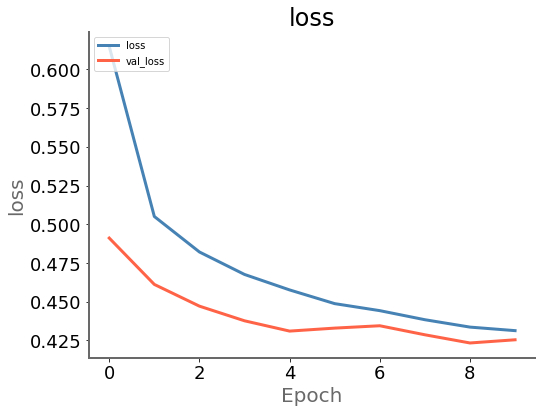

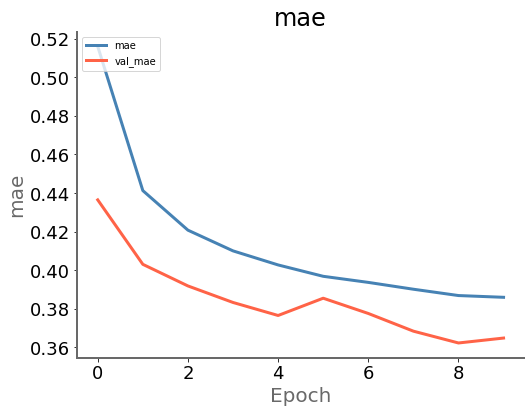

In [10]:
pwk.plot_history(history,plot={'loss':['loss','val_loss'], 'mae':['mae','val_mae']}, save_as='01-history')

## Step 5 - Predict

### 5.1 - Load model

In [11]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')

### 5.2 Make a prediction
A basic prediction, with normalized values (so humanly not very understandable)

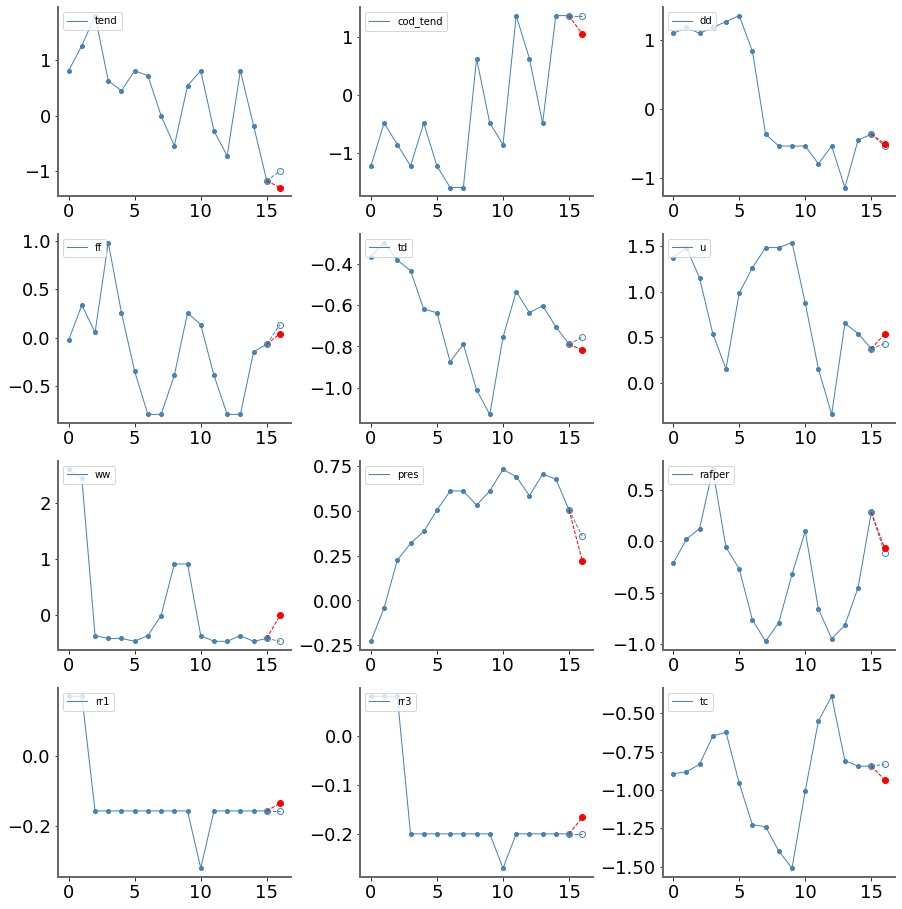

In [12]:
s=random.randint(0,len(dataset_test)-sequence_len)

sequence      = dataset_test[s:s+sequence_len]
sequence_true = dataset_test[s:s+sequence_len+1]

pred = loaded_model.predict( np.array([sequence]) )

# ---- Show result
pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-prediction-norm')


### 5.3 Real prediction
We are now going to make a true prediction, with an un-normalized result

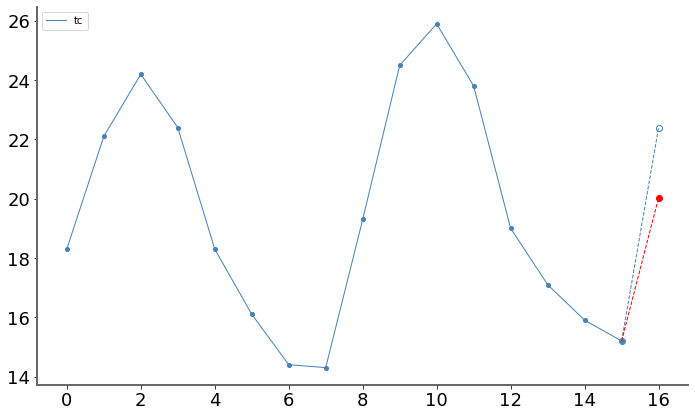

Gap between prediction and reality : 2.36 °C


In [13]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


# ---- Get a sequence

i=random.randint(0,len(dataset_test)-sequence_len)
sequence      = dataset_test[i:i+sequence_len]
sequence_true = dataset_test[i:i+sequence_len+1]

# ---- Prediction

pred = loaded_model.predict( np.array([sequence]) )

# ---- De-normalization

sequence_true = denormalize(mean,std, sequence_true)
pred          = denormalize(mean,std, pred)

# ---- Show it
feat=11

pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8, save_as='03-prediction')

delta_deg=abs(sequence_true[-1][feat]-pred[-1][feat])
print(f'Gap between prediction and reality : {delta_deg:.2f} °C')


In [14]:
pwk.end()

End time is : Wednesday 10 February 2021, 10:57:38
Duration is : 00:02:08 817ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>